# Лабораторна робота № 12 

**Тема.** Аналіз кризових подій із використанням Леві альфа-стабільного розподілу

**Мета.** Навчитися використовувати розподіл Леві для диференціації флуктуацій, що виходять за межі нормального розподілу

::: {.callout-note}
## Анотація

У цій лабораторній ми досліджуємо розподіл прибутковості фінансових активів і стабільність певних показників, які ми розраховуємо, cпираючись на ці активи. Зокрема, ми побачимо, що більш високі моменти розподілу прибутковостей з важкими хвостами насправді дуже нестабільні, нескінченні або взагалі не визначені, і що, наприклад, одна єдина точка даних може визначати більшу частину надлишкового ексцесу. Цей факт має досить драматичні наслідки, оскільки популярні моделі, такі як GARCH, базуються на можливості оцінки кінцевого значення ексцесу. Суть, яку ми хочемо донести, полягає в тому, що, не приділяючи особливої уваги повноті фінансових розподілів, не можна очікувати, що моделі будуть працювати за межами навчальної та тестувальної вибірок. Аналітики та трейдери завжди будуть дивуватись новим екстремальним подіям, що, як правило, рідко бувають позитивними.

Представлені тут теоретичні відомості частково базувались на матеріалах компанії [Artifact Research](https://artifact-research.com/blog/)

:::

## Теоретичні відомості

### Імпортуємо необхідні бібліотеки

::: {.callout-important}
## Увага 

Перш за все, для подальшої роботи, нам необхідно буде встановити бібліотеку `pylevy`. Встановити її можна з відповідного [GitHub репозиторію](https://github.com/josemiotto/pylevy/tree/master). Ми у свою чергу завантажимо її напряму через команду `pip install` слідуючим чином:
 
:::

In [1]:
#| output: false

!pip install git+https://github.com/josemiotto/pylevy.git

  Cloning https://github.com/josemiotto/pylevy.git to c:\users\andrii\appdata\local\temp\pip-req-build-u9m2y3c1
  Resolved https://github.com/josemiotto/pylevy.git to commit d6b855ef2ff959db7c4002c1b39b98bd968f60b0
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for PyLevy: filename=PyLevy-1.1-py3-none-any.whl size=22256272 sha256=88ff9ebd2fc4b33b13d9dfadeb6eb64989ba6fccc3b456eb656dc8a1e626fa72
  Stored in directory: C:\Users\Andrii\AppData\Local\Temp\pip-ephem-wheel-cache-li2uphk0\wheels\43\aa\7b\a0df649c28e743a299f1a4e3649b8000bddce7a23f09eebad5
Successfully built PyLevy


  Running command git clone --filter=blob:none --quiet https://github.com/josemiotto/pylevy.git 'C:\Users\Andrii\AppData\Local\Temp\pip-req-build-u9m2y3c1'


Після встановлення необхідного модулю можна приступати до подальшої роботи. 

In [2]:
import numpy as np                 # бібліотека для роботи з масивами чисел
import matplotlib.pyplot as plt    # бібліотека для побудови графіків
import yfinance as yf              # бібліотека для зчитування фінансових даних з Yahoo Finance
import levy                        # бібліотека для роботи з альфа-стабільним розподілом Леві
import pandas as pd                # бібліотека для фільтрації даних та їх обробки
import scienceplots
from scipy.stats import norm, laplace  # бібліотека для побудови теоретичного розподілу Гауса
                                       # та Лапласа
from tqdm import tqdm                  # бібліотека для виводу шкали завантаження

%matplotlib inline

### Виконуємо налаштування рисунків

In [3]:
plt.style.use(['science', 'notebook', 'grid']) # стиль, що використовуватиметься
                                               # для виведення рисунків

size = 16
params = {
    'figure.figsize': (8, 6),            # встановлюємо ширину та висоту рисунків за замовчуванням
    'font.size': size,                   # розмір фонтів рисунку
    'lines.linewidth': 2,                # товщина ліній
    'axes.titlesize': 'small',           # розмір титулки над рисунком
    'axes.labelsize': size,              # розмір підписів по осям
    'legend.fontsize': size,             # розмір легенди
    'xtick.labelsize': size,             # розмір розмітки по осі Ох
    'ytick.labelsize': size,             # розмір розмітки по осі Ох
    "font.family": "Serif",              # сімейство стилів підписів 
    "font.serif": ["Times New Roman"],   # стиль підпису
    'savefig.dpi': 300,                  # якість збережених зображень
    'axes.grid': False                   # побудова сітки на самому рисунку
}

plt.rcParams.update(params)              # оновлення стилю згідно налаштувань

### Зчитування даних 

In [4]:
df = pd.read_csv('databases\^spx_d.csv')
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)
df = df[df.index >= '1950-01-01']

### Важкі хвости та Чорні понеділки

Спочатку ми розглянемо розподіл щоденних прибутковостей індексу S&P 500, починаючи з 1950 року. Нижче буде показано [Pandas dataframe](https://pandas.pydata.org/docs/user_guide/10min.html) `df`, що містить дані OHLC з файлу (ці дані були попередньо завантажені).

In [5]:
df

,Open,High,Low,Close,Volume
Date,,,,,
1950-01-03,16.66,16.66,16.66,16.66,7.000000e+05
1950-01-04,16.85,16.85,16.85,16.85,1.050000e+06
1950-01-05,16.93,16.93,16.93,16.93,1.416667e+06
1950-01-06,16.98,16.98,16.98,16.98,1.116667e+06
1950-01-07,17.09,17.09,17.09,17.09,1.116667e+06
...,...,...,...,...,...
2023-04-10,4085.20,4109.50,4072.55,4109.11,1.951642e+09
2023-04-11,4110.29,4124.26,4102.61,4108.94,2.000949e+09
2023-04-12,4121.72,4134.37,4086.94,4091.95,2.249009e+09


Цей історичний ряд щоденних цін містить 18527 торгових днів. Замість того, щоб дивитися безпосередньо на ціни, ми розглянемо щоденні [*log*-прибутковості](https://lucaslouca.com/Why-Use-Logarithmic-Returns-In-Time-Series-Modelling/) індексу S&P 500. Пам'ятайте, що логарифмічна прибутковість $r_t$ визначається як логарифм відношення між цінами закриття $p_t$ у теперішній момент часу та попередній $p_{t-1}$:

$$
r_t = \log p_t - \log p_{t-1}. 
$$

Логарифмічні прибутковості характеризуються симетрією, тобто якщо в один день індекс втрачає $r_t = -0.1$, а на наступний день індекс набирає $r_{t+1} = +0.1$, індекс знову досягає початкової ціни. Зі звичайними прибутковостями, спочатку втративши $10\%$, а потім знову набравши $10\%$, ви не повернетесь до початкової ціни. Ми зберігаємо прибутковості в новому фреймі даних `lr`:

In [6]:
lr = np.log(df['Close']).diff().dropna()

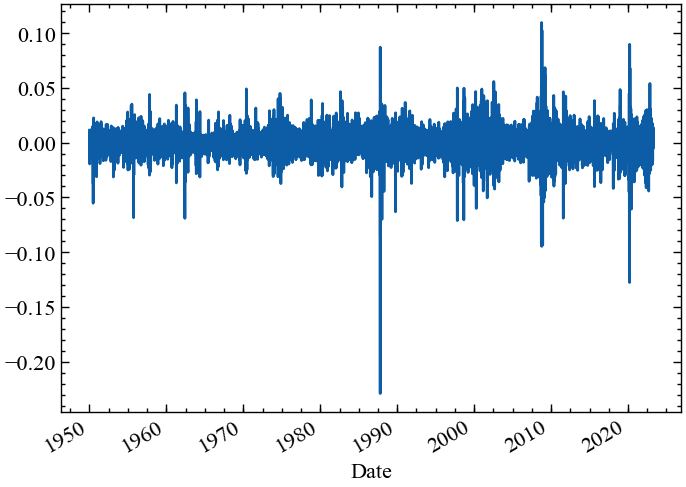

In [7]:
#| label: fig-ret  
#| fig-cap: "Динаміка логарифмічних прибутковостей індексу S&P 500"

lr.plot()
plt.show();

Використовуючи вбудовані функції Pandas та Numpy, тепер ми можемо подивитись на найгірше щоденнє значення прибутковостей. Ми виявляємо, що найгірше значення становило $-0.229$, що відповідає $-22.9\%$, і що це сталося в понеділок, 19 жовтня 1987 року --- так званий [*Чорний понеділок*](https://en.wikipedia.org/wiki/Black_Monday_(1987)).

In [8]:
# найгірший щоденні прибутковості від закриття до закриття
lr.min()

-0.2289972265656708

In [9]:
# відповідні арифметичні прибутковості
np.exp(lr.min()) - 1

-0.20466926070038938

In [10]:
# індекс найгіршого значення
np.argmin(lr)

9583

In [11]:
df.iloc[9583:9585]

,Open,High,Low,Close,Volume
Date,,,,,
1987-10-16,298.08,298.92,281.52,282.70,188055556.0
1987-10-19,282.70,282.70,224.83,224.84,335722222.0


Далі ми будуємо графік вибіркового розподілу щоденних логарифмічних прибутковостей, що демонструє нам, як часто ми спостерігаємо щоденні прибутковості певного знака та величини. Зверніть увагу, що ми встановили логарифмічне масштабування для вісі Оy, щоб мати краще представлення про хвости розподілу, тобто дуже великі, але рідкісні негативні та позитивні прибутковості --- крахи та підйоми:

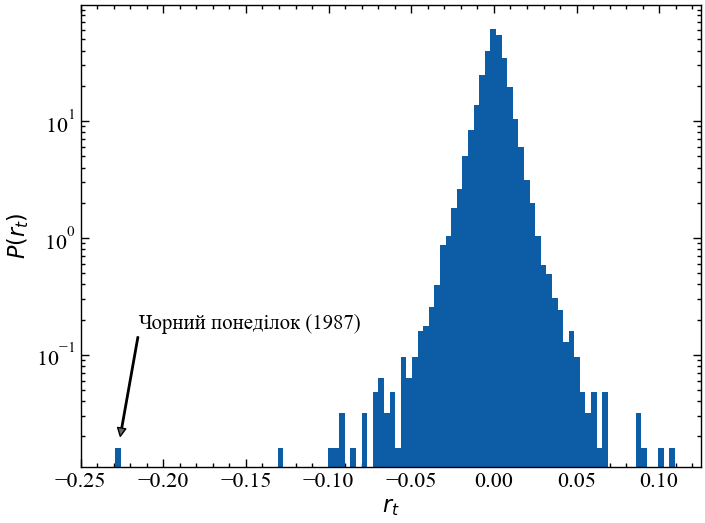

In [12]:
#| label: fig-hist-ret  
#| fig-cap: "Розподіл імовірностей логарифмічних прибутковостей S&P 500 в напів- логарифмічному масштабі"

plt.figure()
plt.hist(lr, 100, density=True)
plt.yscale('log')
plt.ylabel(r'$P(r_t)$')
plt.xlabel(r'$r_t$')
plt.xlim([-0.25, 0.125])
plt.ylim([0.011, 99])
plt.annotate('Чорний понеділок (1987)', [-0.226, 0.02], xytext=[-0.215, 0.15],
             arrowprops=dict(facecolor='0.4', width=1, headwidth=6, headlength=6),
             ha='left', va='bottom', fontsize=15)
plt.show();

Як ми можемо описати погіршення розподілу прибутковості? За допомогою [логарифмічного масштабування](https://en.wikipedia.org/wiki/Logarithmic_scale) осі Oy, щоб експоненціальний спад виглядав лінійно, тому ми могли би запідозрити, що при малих абсолютних значеннях прибутковості розподіл зменшується експоненціально, але в міру збільшення абсолютних значень прибутковостей ми все більше і більше відхиляємося від початкового нахилу. Насправді, ми можемо показати, що ні розповсюджений [розподіл Гауса](https://en.wikipedia.org/wiki/Normal_distribution) (так званий *нормальний* розподіл), ні [розподіл Лапласа](https://en.wikipedia.org/wiki/Laplace_distribution) з його експоненціальним спадом з обох сторін точно не можуть змоделювати розподіл прибутковостей S&P 500. Як розподіл Гауса, так і розподіл Лапласа недооцінюють ймовірність екстремальних подій --- підйомів та крахів:

In [13]:
# підганяємо розподіл Гауса та Лапласа під дані
norm_loc, norm_scale = norm.fit(lr)
laplace_loc, laplace_scale = laplace.fit(lr)

# генеруємо значення (x,y) з використанням отриманих параметрів розподілів
x_fit = np.linspace(-0.25, 0.125, 1000)
y_fit_norm = norm(loc=norm_loc, scale=norm_scale).pdf(x_fit)
y_fit_laplace = laplace(loc=laplace_loc, scale=laplace_scale).pdf(x_fit)

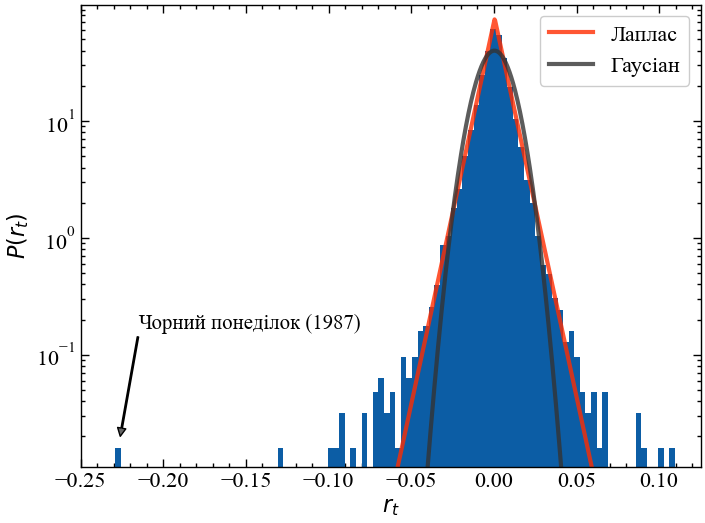

In [14]:
#| label: fig-hist-ret-laplacian-gauss 
#| fig-cap: "Розподіл імовірностей логарифмічних прибутковостей S&P 500 у порівнянні 
#| з розподілами Гауса й Лапласа в напів- логарифмічному масштабі"

plt.figure()
plt.hist(lr, 100, density=True)
plt.plot(x_fit, y_fit_laplace, lw=3, c='C3', alpha=0.8, label='Лаплас')
plt.plot(x_fit, y_fit_norm, lw=3, c='0.2', alpha=0.8, label='Гаусіан')
plt.yscale('log')
plt.ylabel(r'$P(r_t)$')
plt.xlabel(r'$r_t$')
plt.xlim([-0.25, 0.125])
plt.ylim([0.011, 99])
plt.legend()

plt.annotate('Чорний понеділок (1987)', [-0.226, 0.02], xytext=[-0.215, 0.15],
             arrowprops=dict(facecolor='0.4', width=1, headwidth=6, headlength=6),
             ha='left', va='bottom', fontsize=15)

plt.show();

### Відхилення в 23 сигма

Як ми можемо бачити вище, як розподіл Гауса, так і розподіл Лапласа різко недооцінюють ймовірність дуже волатильної динаміки! Часто зазначають, що трапилась "[3-сигма](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule) подія на ринку" або щось подібне, тому що багатьом людям подобається оцінювати індивідуальні прибутковості по [стандартному відхиленню](https://en.wikipedia.org/wiki/Standard_deviation) (зване "сигмою") підібраного гаусового розподілу. Однак, якщо Розподіл Гауса взагалі не відповідає розподілу вибірки, як у нашому випадку, оцінка краху в одиницях "сигма" може ввести в оману! Щоб показати це, ми спочатку перевіримо, на скільки сигм ринок змістився в Чорний понеділок 1987 року:

In [15]:
np.abs(np.min(lr))/np.std(lr, ddof=1)

22.969393251617504

Виходячи з розподілу Гауса, Чорний понеділок був би подією з "23 сигмами"! Тепер розподіл Гауса чітко говорить нам, як часто X-сигма подія має відбуватися:

- 1-сигма: прибл. 1 з 3 днів
- 2-сигма: прибл. 1 з 22 днів
- 3-сигма: прибл. 1 з 370 днів

...

Ми можемо розширити цю таблицю, попрацювавши з [функцією кумулятивного розподілу](https://en.wikipedia.org/wiki/Cumulative_distribution_function), тісно пов'язана з [функцією виживання](https://en.wikipedia.org/wiki/Survival_function), і перемістивши обчислення в логарифмічний простір для чисельної стабільності, як демонструють наступні комірки коду:

In [16]:
# у середньому, як багато днів між 1-сигма подіями?
1/(2*(1. - norm.cdf(1.)))

3.1514871875343764

In [17]:
# у середньому, як багато днів між 2-сигма подіями?
1/(2*(1. - norm.cdf(2.)))

21.97789450799283

In [18]:
# у середньому, як багато днів між 3-сигма подіями?
1/(2*(1. - norm.cdf(3.)))

370.3983473449564

In [19]:
# те саме, що й вище, але із використанням функції виживання
1/(2*norm.sf(3.))

370.3983473449592

In [20]:
# те саме, що й вище, але із використанням логарифмічної функції функції виживання для чисельної стабільності
np.exp(-norm.logsf(3.) - np.log(2.))

370.398347344959

In [21]:
# те саме, що й вище, але із використанням логарифму з основою 10 для замість натурального логарифму для кращої інтерпретації
10**(-norm.logsf(3.)/np.log(10) - np.log10(2.))

370.3983473449588

In [22]:
# як багато днів (log10 значення) між 23-сигма подіями, в середньому?
(-norm.logsf(23.)/np.log(10) - np.log10(2.))

116.33149536636726

Щоб отримати додаткову інформацію про частоту екстремальних прибутковостей, ми можемо навіть створити невеликий [інтерактивний віджет](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Basics.html) за допомогою повзунка, який вказує кількість "сигм", а текст поруч із ним показує середню кількість днів між двома такими екстремальними подіями:

In [23]:
from ipywidgets import IntSlider, interact

def years_between(X):
    log10_days = (-norm.logsf(X)/np.log(10) - np.log10(2.))
    days = int(10**log10_days)
    return f'У середньому, між двома X-сигма подіями, варто очікувати {days} дні(в), (день).'

interact(years_between, X=IntSlider(min=1, max=23, step=1, value=1));

interactive(children=(IntSlider(value=1, description='X', max=23, min=1), Output()), _dom_classes=('widget-int…

In [24]:
np.log10(float(214533622638557983431869220329015643677794364342592664885632499326649056583365324378194575664549945880382591666749440))

116.33149536636726

Ви бачите, що при переміщенні повзунка вправо кількість днів або років між двома наступними "X-сигма" подіями швидко наростає. Наша таблиця тепер виглядає наступним чином:

- 1-сигма: прибл. 1 з 3 днів
- 2-сигма: прибл. 1 з 22 днів
- 3-сигма: прибл. 1 з 370 днів

...   

- 23-сигма: приблизно 1 з $10^{116}$ днів (!!!)

Внесемо ясність: виходячи з розподілу Гауса, щоденні втрати Чорної п'ятниці 1987 року повинні бути подією, яку ми очікуємо раз на $10^{116}$ днів. Це число в значній мірі незбагненно велике. Якби S&P 500 почав торгуватися відразу після [народження Всесвіту](https://en.wikipedia.org/wiki/Age_of_the_universe), це становило б лише $10^{13}$ торгових днів. Через $10^{116}$ днів усі зірки у Всесвіті давно згорять, навіть усі [чорні діри випаруються](https://en.wikipedia.org/wiki/Future_of_an_expanding_universe#Dark_Era_and_Photon_Age) і Всесвіт стане темним і порожнім місцем. Тож або ми повинні бути дуже щасливі, що єдина очікувана Чорна п'ятниця в історії та майбутньому Всесвіту позаду, або ви дійсно ніколи не повинні використовувати розподіл Гауса для моделювання прибутковості акцій! Незалежно від ринку та деталей, якщо хтось говорить про події з 10 сигмами або 23 сигмами, він, безумовно, використовує неправильну модель, оскільки шанс спостерігати таку подію в нашому житті незначний.

Отже, виникає питання: як ми справляємось із такими екстремальними значеннями? Чи слід позначати їх як [викиди](https://en.wikipedia.org/wiki/Outlier) або артефакти, щоб наші фінансові моделі краще описували більшість значень? Звичайно, ні, оскільки результат наших інвестицій може критично залежати не від більшості менших прибутковостей, а саме від таких екстремальних подій! Далі ми познайомимося з підходом, який може пояснити та екстраполювати за межі екстремальних подій, таких як Чорний понеділок. Але ми також побачимо, що не всі способи врахування важких хвостів розподілів працюють добре, оскільки деякі моделі, такі як [GARCH](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity) може заколисати нас помилковим почуттям безпеки, коли ми завжди беремо до уваги минулі екстремальні події, але завжди дивуємося новим.

### Статистика степеневого розподілу

Тепер, коли ми знаємо, що розподіл Гауса не є хорошим вибором, який тип розподілу насправді може описати частоту екстремальних подій, що струшують S&P 500? Частота екстремально позитивних і негативних прибутковостей асиметрична для більшості фінансових активів, оскільки крахи, як правило, більш сильні, ніж підйоми. Ось чому нижче ми зосередимося на лівому (негативному) хвості розподілу прибутковостей.

Оскільки нас цікавлять лише екстремальні події, ми розглянемо лише ті прибутковості, які менше $-0.03$ (приблизно три стандартних відхилення від середнього значення). Нижче ми візуалізуємо ці екстремально негативні показники прибутковостей у [логарифмічному масштабі](https://en.wikipedia.org/wiki/Log%E2%80%93log_plot) (тут ми використовуємо абсолютні значення негативних прибутковостей). Як вісь Oy (яка показує частоту логарифмічних прибутковостей), так і вісь Ox (яка показує величину логарифмічних прибутковостей) масштабуються логарифмічно:

In [25]:
# хвіст починається приблизно при трьох стандартних відхиленнях від середнього
np.mean(lr) - 3*np.std(lr)

-0.029610514264246313

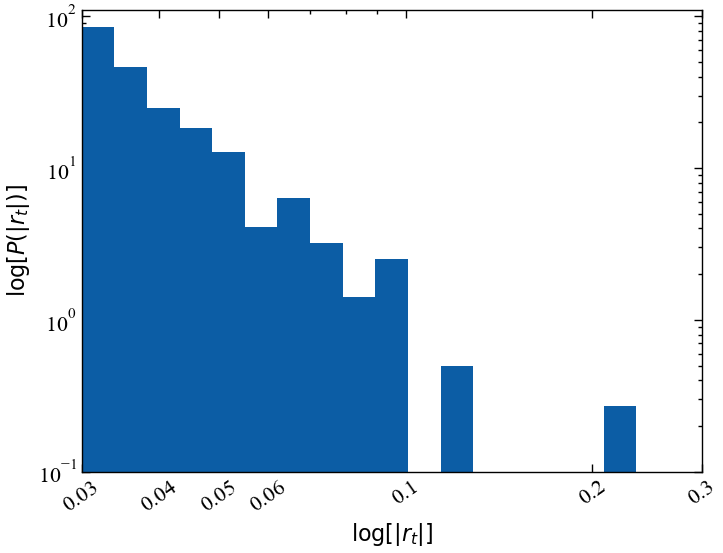

In [26]:
#| label: fig-hist-negret 
#| fig-cap: "Розподіл імовірностей щоденних негативних абсолютних прибутковостей у подвійному логарифмічному масштабі"

neg_lr = -lr[lr < 0]

plt.figure()
hist = plt.hist(neg_lr, bins=np.logspace(np.log10(0.03),np.log10(0.3), 20), density=True)
plt.yscale("log")
plt.xscale("log")
plt.ylabel(r'$\log[P(|r_t|)]$')
plt.xlabel(r'$\log[|r_t|]$')

plt.ylim([0.1, 110])
plt.xlim([0.03, 0.3])
plt.xticks([0.03, 0.04, 0.05, 0.06, 0.1, 0.2, 0.3], [0.03, 0.04, 0.05, 0.06, 0.1, 0.2, 0.3], rotation=35)
plt.show();

Як ми бачимо, ця гістограма екстремальних абсолютних прибутковостей зменшується приблизно лінійно при логарифмічному масштабуванні. Щоразу, коли ви виявляєте пряму лінію на логарифмічному графіку, це вказує на так званий [степеневий розподіл](https://en.wikipedia.org/wiki/Power_law). Степеневе співвідношення ймовірності спостереження великих абсолютних логарифмічних прибутковостей задається у вигляді:

$$
p(|r_t|) = c \cdot |r_t|^{-\alpha}. 
$$

Константа $c$ на даний момент нас не надто турбує, вона просто гарантує, що ліва частина рівняння належним чином нормалізована, але показник $\alpha$ представляє найбільший інтерес, оскільки він говорить, як працює степеневий закон. Якщо ви знаєте частоту даних абсолютних логарифмічних прибутковостей, то степеневий закон підкаже, у скільки разів менш імовірними були б логарифмічні прибутковості подвоєного розміру:

$$
p(2 \cdot |r_t|) = c \cdot (2 \cdot |r_t|)^{-\alpha} = 2^{-\alpha} \cdot c \cdot |r_t|^{-\alpha} = 2^{-\alpha} \cdot p(|r_t|), 
$$

або простіше:

$$
p(2 \cdot |r_t|) \big/ p(|r_t|) = 2^{-\alpha}. 
$$

Для $\alpha = 0$ всі прибутковості однаково ймовірні, для $\alpha = 2$ подвоєння прибутковостей робить їх у 4 рази менш імовірними. Це правило подвоєння вгору або вниз не залежить від значення самого $\left| r_t \right|$, але працює для всіх значень $\left| r_t \right|$. Степеневе співвідношення також називають "безмасштабним" або [масштабно-інваріантним](https://en.wikipedia.org/wiki/Scale_invariance).

Як щодо показника $\alpha$ для наших надзвичайно негативних логарифмічних прибутковостей S&P 500? Ми можемо легко оцінити його за даними, але є деякі тонкощі у правильному розбитті вищезазначеної гістограми, які можуть вплинути на нашу оцінку (див., наприклад, [@10.1890/07-1288.1]). Щоб обійти ці проблеми з розбиттям, можемо замість цього оцінити степеневий показник [кумулятивної гістограми](https://en.wikipedia.org/wiki/Histogram#Cumulative_histogram) логарифмічних прибутковостей, а потім відняти одиницю від отриманого нахилу:

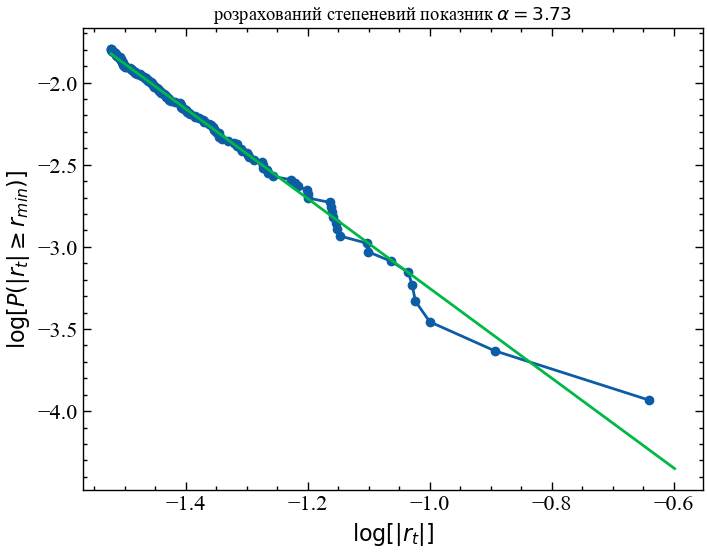

In [27]:
#| label: fig-cumulativehist-negret 
#| fig-cap: "Кумулятивний розподіл імовірностей негативних абсолютних прибутковостей у подвійному логарифмічному масштабі й
#| лінія регресії з якої отримується кут нахилу даного розподілу"

# підганяємо лінію регресії до кумулятивної гістограми (log10 для ймовірності) vs. лог-прибутковості (log10)
sorted_neg_lr = np.sort(neg_lr.values)
cumulative_probability = np.linspace(1, 0, len(sorted_neg_lr)+1)[:-1]

x_min = 0.03
mask = sorted_neg_lr >= x_min
m, b = np.polyfit(np.log10(sorted_neg_lr[mask]), np.log10(cumulative_probability[mask]), 1)
alpha = -(m - 1)

plt.figure()
plt.plot(np.log10(sorted_neg_lr[mask]), np.log10(cumulative_probability[mask]))
plt.scatter(np.log10(sorted_neg_lr[mask]), np.log10(cumulative_probability[mask]), label='sample data')

x_fit = np.linspace(np.log10(x_min), np.log10(1.1*np.max(neg_lr)), 100)
y_fit = m*x_fit + b

plt.plot(x_fit, y_fit, label='степенева підгонка')
plt.title(f'розрахований степеневий показник $\\alpha={alpha:.2f}$')
plt.ylabel(r'$\log[P(|r_t| \geq r_{min})]$')
plt.xlabel(r'$\log[|r_t|]$')
plt.show();

Виходячи з цієї оцінки, ми отримуємо степеневої показник, рівний $\alpha \approx 3.7$. Якщо ми побудуємо гістограму наших надзвичайно негативних логарифмічних прибутковостей, то побачимо, що вона добре відображає зниження ймовірності, оскільки масштаб збоїв збільшується. Однак цей степеневий показник все ще недооцінює ймовірність настання чергового "Чорного понеділка", оскільки лінія відповідності не ідеально підходить до цієї крайньої точки. Якби ми захотіли створити ще більш консервативну модель екстремальних подій, нам потрібно було б вручну ще більше зменшити значення $\alpha$, щоб врахувати більшу ймовірність настання чорних понеділків за рахунок втрати точності підгонки для менших збоїв. Це перший раз, коли ми можемо побачити, як одна точка даних впливає на наші рішення щодо моделювання. На даний момент ми будемо довіряти оцінці параметра і погодимося з оцінкою $\alpha=3.7$.

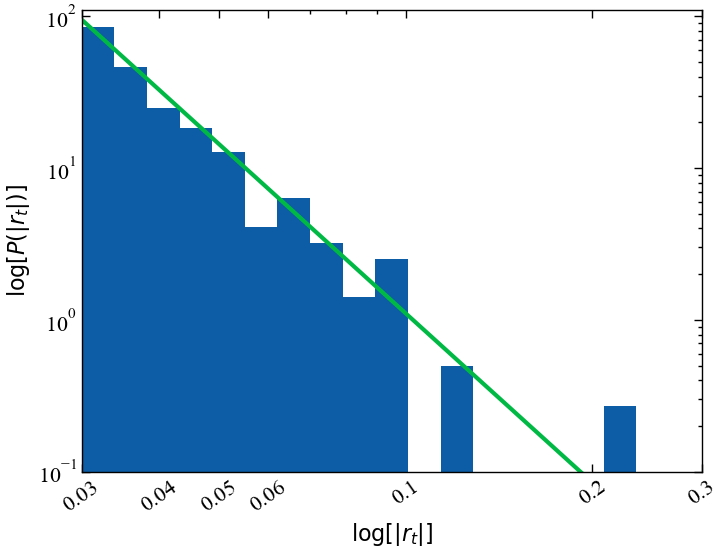

In [28]:
#| label: fig-hist-negret-reg
#| fig-cap: "Розподіл імовірностей щоденних негативних абсолютних прибутковостей у подвійному логарифмічному масштабі й
#| лінія регресії з якої отримується кут нахилу даного розподілу"

neg_lr = -lr[lr < 0]

plt.figure()
hist = plt.hist(neg_lr, bins=np.logspace(np.log10(0.03), np.log10(0.3), 20), density=True)
plt.yscale("log")
plt.xscale("log")
plt.ylabel(r'$\log[P(|r_t|)]$')
plt.xlabel(r'$\log[|r_t|]$')
plt.ylim([0.1, 110])
plt.xlim([0.03, 0.3])
plt.xticks([0.03, 0.04, 0.05, 0.06, 0.1, 0.2, 0.3], [0.03, 0.04, 0.05, 0.06, 0.1, 0.2, 0.3], rotation=35);

x_fit = np.logspace(np.log10(0.03),np.log10(0.3), 100)
y_fit = 0.00022*(x_fit**-3.7)

plt.plot(x_fit, y_fit, lw=3)
plt.show();

Ми можемо використовувати цей степеневий закон, щоб екстраполювати, як часто ми очікуємо настання чорного понеділка (або "події з 23 сигмами") у довгостроковій перспективі. Виходячи з наявних у нас даних, ми можемо оцінити, що ймовірність спостереження зниження на $-0.03$ або гірше становить близько $1.6\%$. Слідуючи нашій степеневій кривій, така крахова подія як чорний понеділок, що мала спад на $-0.229$, відбувалася б із частотою $\left(0.229/0.03\right)^{-3.7} \approx 1/1845$. Так само часто, як зниження на $-0.03$, яке ми спостерігаємо приблизно раз на три місяці. Це означає, що, виходячи з нашої степеневої кривої, очікується, що чорні понеділки, подібні до 1987 року, траплятимуться приблизно раз на 450 років (див. код нижче).

In [29]:
# як часто ринок знижується більш ніж на -0.03
(neg_lr > 0.03).mean()

0.016091417910447763

In [30]:
# у середньому, як багато днів між цима трьома подіями
1./(neg_lr > 0.03).mean()

62.144927536231876

In [31]:
# у скільки разів менше відбувається подій "Чорного понеділка" в порівнянні зі зниженням на -0.03?
(np.max(neg_lr)/0.03)**3.7

1845.1139014672306

In [32]:
np.max(neg_lr)

0.2289972265656708

In [33]:
# скільки років пройшло між двома подіями "Чорного понеділка",
# виходячи з припущення, що подія -0.03 відбувається один раз у 63 дня?
(1./((1/62)*1/1845))/252

453.92857142857144

Якби ми включили більше даних, що містять інші приклади екстремальних подій, наприклад, з [Великої депресії](https://en.wikipedia.org/wiki/Great_Depression), ця оцінка може стати ще меншою. Аналогічно, якби ми скоригували степеневий показник так, щоб він був більш консервативним, ніж передбачає наш простий метод оцінки, ми також отримали б коротший період. Хоча 460 років все ще є дуже великим періодом, це набагато більш реалістична оцінка порівняно з $10^{114}$ роками, які ми отримали, використовуючи розподіл Гауса. Однією з переваг степеневої моделі є її здатність до екстраполяції: використовуючи степеневу оцінку $\alpha$ та частоту менших прибутковостей, щодо яких ми маємо достовірні дані, ми можемо оцінити частоту майбутніх серйозних збоїв, щодо яких ми ще не отримали жодних даних. Ще одну перевагу оцінки $\alpha$ ми розглянемо далі.

::: {.callout-tip}
## ПРИМІТКА

Не існує такого поняття, як "подія з 10 сигмами"! Справжня подія з 10 сигмами настільки неймовірно рідкісна, що пережити її протягом нашого життя --- мізерно мало. Екстремальні події, безумовно, трапляються, але вони не можуть бути описані за допомогою "сигм", їх потрібно враховувати і екстраполювати з використанням степеневих законів. Завжди будьте обережні, коли аналітики виправдовують себе за те, що вони не були готові до "події з 10 сигмами", оскільки це вказує на те, що їх моделі ризиків вкрай недосконалі

:::

### Статистичні моменти під впливом важких хвостів

Чому все це так важливо? Степенневий показник $\alpha$ насправді багато говорить нам про стабільність і збіжність [моментів розподілу ймовірностей](https://en.wikipedia.org/wiki/Moment_(mathematics)), і це, в свою чергу, має значення для деяких найбільш часто використовуваних моделей у фінансах. Перші чотири центральні моменти --- це:

1. **[Середнє](https://en.wikipedia.org/wiki/Expected_value)**: очікуване значення розподілу.
2. **[Дисперсія](https://en.wikipedia.org/wiki/Variance)**: Квадрат стандартного відхилення, який часто використовується для оцінки волатильності на основі розподілу прибутковостей.
3. **[Асиметрія](https://en.wikipedia.org/wiki/Skewness)**: вимірює зміщення розподілу. Розподіл прибутковостей, як правило, має негативну асиметрію, оскільки збої є більш стрімкими, ніж підйоми.
4. **[Ексцес](https://en.wikipedia.org/wiki/Kurtosis)**: вимірює тяжкість хвостів розподілу. Розподіли прибутковостей зазвичай мають ексцес більший ніж у розподілу Гауса, тобто екстремальні події відбуваються частіше, ніж очікувалося в гаусовій моделі.

Ексцес Гаусового розподілу дорівнює 3 (використовуючи визначення Пірсона, з визначенням Фішера [надлишкового ексцесу](https://en.wikipedia.org/wiki/Kurtosis#Excess_kurtosis) це 0), але наша вибірка щоденних логарифмічних прибутковостей S&P 500 має ексцес $28.6$, що знову вказує на те, що екстремальні події набагато більш вірогідні.

In [34]:
# обчислюємо ексцес лог-прибутковостей
from scipy.stats import kurtosis

kurtosis(lr, fisher=False, bias=False)

28.610931957080663

Тепер ми дійшли до того моменту, коли ми могли б запитати: наскільки сильно одна точка впливає на нашу оцінку ексцесу? Якщо ми перерахуємо ексцес всіх щоденних прибутків S&P 500 з 1950 року і виключимо тільки чорний понеділок 1987 року, ми отримаємо значення $14.3$, майже половину від значення, яке ми отримуємо, коли використовуємо всі значення! Видалення подальших найгірших днів, звичайно, ще більше зменшує ексцес, але ефект значно менший.

In [35]:
# обчислюємо ексцес лог-прибутковостей після видалення Чорного понеділка 1987
kurtosis(lr[lr > np.min(lr)], fisher=False, bias=False)

14.3083633314701

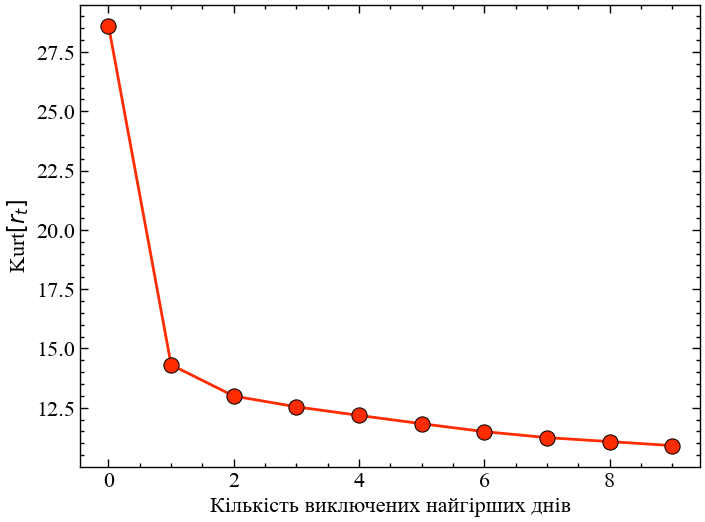

In [38]:
#| label: fig-excess
#| fig-cap: "Залежність ексцесу логарифмічних прибутковостей від кількості видалених найгірших днів на ринку S&P 500"

lr_sorted = lr.sort_values()
kurt = [kurtosis(lr_sorted.iloc[i:], fisher=False, bias=False) for i in range(10)]

plt.figure()
plt.plot(np.arange(10), kurt, c='C3', lw=2, zorder=2)
plt.scatter(np.arange(10), kurt, s=120, lw=0.75, edgecolor='k', facecolor='C3', zorder=3)
plt.xlabel('Кількість виключених найгірших днів')
plt.ylabel(r'Kurt$[r_t]$')
plt.show();

Більш радикальний погляд на цю проблему досягається, якщо ми будуємо графік ексцесу в покроковому режимі, тобто для кожного дня ми будуємо розрахунковий ексцес, використовуючи всі минулі логарифмічні дані до цього моменту часу. Як ви можете бачити нижче, до "Чорного понеділка" ексцес ніколи не перевищував $15$, проте навіть через 35 років після "Чорного понеділка" ексцес ще не "оговтався" від цієї події і залишається на позначці 30. Чи означає це, що ми повинні просто ігнорувати Чорний понеділок як викид і продовжувати використовувати нашу "чисту" оцінку в $14.6$? Ні, точно ні! Як ми побачимо незабаром, ми скоріше повинні запитати себе, чи є сенс у тому, щоб оцінювати ексцес!

In [41]:
kurt = [kurtosis(lr.iloc[:i], fisher=False, bias=False) for i in tqdm(range(1000, len(lr)))]

100%|██████████| 17526/17526 [00:09<00:00, 1937.85it/s]


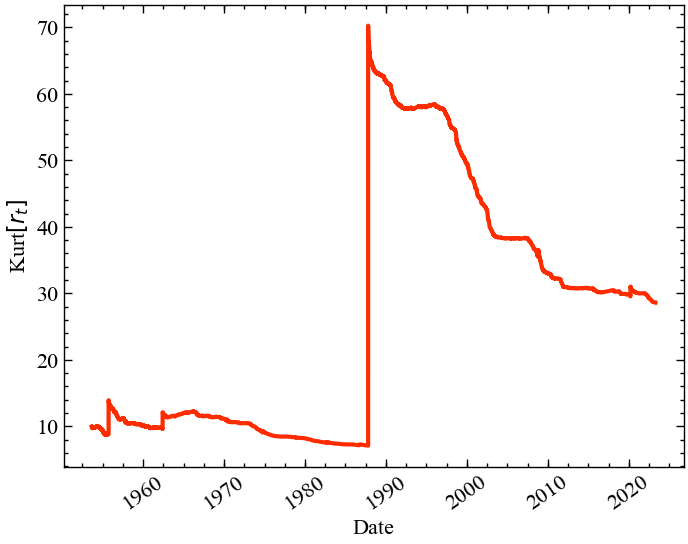

In [42]:
#| label: fig-excess-date
#| fig-cap: "Залежність ексцесу логарифмічних прибутковостей від кількості включених значень індексу S&P 500"

plt.figure()
plt.plot(lr.index[1000:], kurt, c='C3', lw=3, zorder=2)
plt.xlabel('Date')
plt.ylabel(r'Kurt$[r_t]$')
plt.xticks(rotation=35)
plt.show();

Той факт, що одна точка даних може настільки сильно змінити нашу оцінку ексцесу, і, схоже, вона більше не сходиться, коли додаються нові точки даних, є чітким свідченням того, що ексцес базового розподілу ймовірностей насправді нескінченний! Проблема полягає в тому, що для кінцевої вибірки даних (а всі набори даних скінченні) ми завжди зможемо оцінити скінчене значення ексцесу. `scipy.stats.kurtosis` не може повернути нескінченність ($\infty$), він завжди повідомлятиме про скінченний ексцес *вибірки*. Але ця кінцева оцінка не допоможе нам нічого сказати про майбутню поведінку ринку, оскільки ексцес продовжуватиме переходити до ще більших значень до наступного чорного понеділка, іншого чорного вівторка ... у більш-менш віддаленому майбутньому.

Однак опис частоти екстремальних подій згідно степеневого закону, який ми представили вище, може допомогти нам вирішити, чи є ексцес кінцевим, так що, переглянувши достатню кількість точок даних, ми зможемо вирішити, чи слід прийняти той факт, що ексцес не піддається оцінці і справді нескінченний. Щоб побачити це, нам потрібно ввести ще один розподіл ймовірностей, [t-розподіл Стьюдента](https://en.wikipedia.org/wiki/Student%27s_t-distribution). Це колоколообразний симетричний розподіл зі степеневими хвостами. Його додатковий параметр $\nu$ визначає показник степеневого закону $\alpha=(\nu+1)$. Нижче ми підганяємо t-розподіл до наших логарифмічних прибутковостей S&P 500, зберігаючи при цьому степеневий показник $\alpha=3.7$ (відповідний $\nu = 2.7$), який ми підганяли раніше:

In [43]:
from scipy.stats import t

fit_params = t.fit(lr, fix_df=2.7)

x_fit = np.linspace(-0.25, 0.125, 1000)
y_fit_t = t(*fit_params).pdf(x_fit)

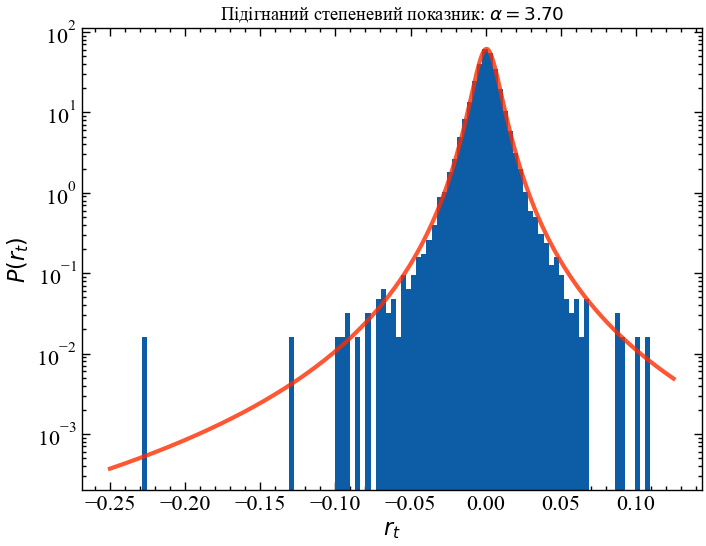

In [45]:
#| label: fig-hist-ret-student 
#| fig-cap: "Розподіл імовірностей логарифмічних прибутковостей S&P 500 у порівнянні 
#| з розподілами Гауса й Лапласа в напів- логарифмічному масштабі"

plt.figure()
plt.hist(lr, 100, density=True)
plt.plot(x_fit, y_fit_t, lw=3, c='C3', alpha=0.8, label="Підігнаний t-розподіл")
plt.yscale('log')
plt.ylabel(r'$P(r_t)$')
plt.xlabel(r'$r_t$')

plt.title(f'Підігнаний степеневий показник: $\\alpha = {(fit_params[0]+1):.2f}$')
plt.show();

Звичайно, можна поставити під сумнів, чи дійсно t-розподіл Стьюдента добре відповідає нашим логарифмічним прибутковостям, оскільки він переоцінює частоту абсолютних прибутковостей і все ще недооцінює ймовірність настання Чорного понеділка. На даний момент ми ігноруємо ці деталі та зосереджуємось на ексцесі t-розподілу Стьюдента та зв'язку зі степеневим показником $\alpha$:

- $\text{Kurt} = 6/(\nu-4) + 3~$ для $~\nu > 4~$ або $~\alpha > 5$;
- $\text{Kurt} = \infty~~~~~~~~~~\,$ для $~2 < \nu \leq 4~$ або $~3 < \alpha \leq 5$;
- інакше невизначено.

Це підтверджує наше початкове припущення про те, що при степеневому показнику, рівному $\alpha \approx 3.7$, ексцес дійсно нескінченний, і немає сенсу оцінювати його по скінченій вибірці, оскільки оціночне значення буде зберігатися тільки до наступної екстремальної події, яка підштовхне його ще вище. Ми можемо легко змоделювати цей ефект, витягуючи випадкові вибірки з t-розподілів Стьюдента з різними степеневими показниками, які відповідають трьом режимам, зазначеним вище. Далі ми генеруємо 100 000 випадкових значень з t-розподілів з $\alpha = 2$, $\alpha = 3.7$, $\alpha = 6$, і поетапно обчислюємо ексцес, як і раніше, щоб побачити еволюцію передбачуваного ексцесу у трьох різних випадках:

In [46]:
np.random.seed(1)
samples_alpha_20 = t(1.0, 0., 1.).rvs(100000)
samples_alpha_37 = t(2.7, 0., 1.).rvs(100000)
samples_alpha_60 = t(5.0, 0., 1.).rvs(100000)

In [47]:
m = np.arange(1000, 100000, 50)
kurt_alpha_20 = [kurtosis(samples_alpha_20[:i], fisher=False, bias=False) for i in m]
kurt_alpha_37 = [kurtosis(samples_alpha_37[:i], fisher=False, bias=False) for i in m]
kurt_alpha_60 = [kurtosis(samples_alpha_60[:i], fisher=False, bias=False) for i in m]

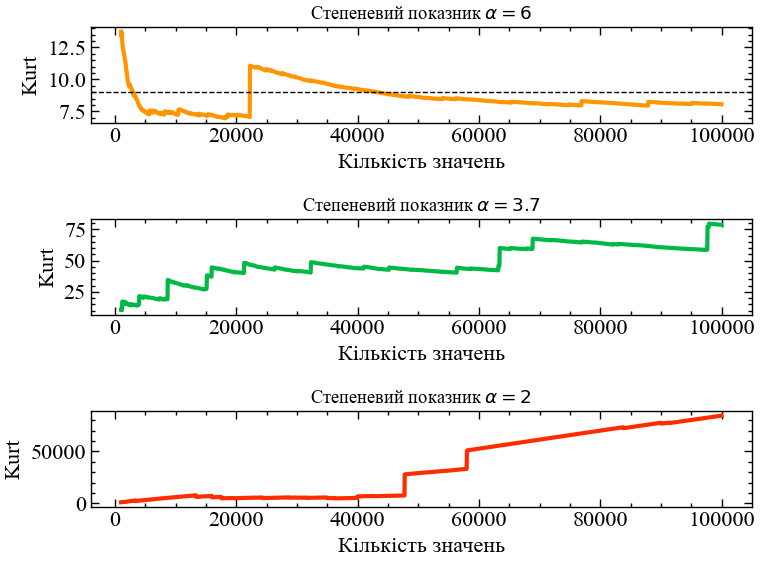

In [50]:
#| label: fig-hist-ret-student-alphas
#| fig-cap: "Випадкові значення згенеровані з $t$-розподілів при $\\alpha=2$, $\\alpha=3.7$ та $\\alpha=6$"

plt.figure()

plt.subplot(311)
plt.plot(m, kurt_alpha_60, c='C2', lw=3, zorder=2)
plt.axhline(6/(5-4) + 3, lw=1, ls='--', c='k')
plt.ylabel('Kurt')
plt.xlabel('Кількість значень')
plt.title('Степеневий показник $\\alpha=6$')

plt.subplot(312)
plt.plot(m, kurt_alpha_37, c='C1', lw=3, zorder=2)
plt.ylabel('Kurt')
plt.xlabel('Кількість значень')
plt.title('Степеневий показник $\\alpha=3.7$')

plt.subplot(313)
plt.plot(m, kurt_alpha_20, c='C3', lw=3, zorder=2)
plt.ylabel('Kurt')
plt.xlabel('Кількість значень')
plt.title('Степеневий показник $\\alpha=2$')

plt.tight_layout()
plt.show();

У випадку $\alpha=6$ ($\nu=5$) ексцес скінченний і повинен приймати значення $6/(\nu - 4)+3=9$. Хоча ми бачимо деякі коливання, оціночне значення ексцесу повільно наближається до справжнього значення. Для прикладу, який відповідає степеневому показнику індексу S&P 500 з $\alpha = 3.7$, моделювання показує таку ж поведінку, що і для реальних даних: збіжність не може бути виявлена, скоріше кожна екстремальна подія збільшує ексцес; при нескінченних вибірках ми би досягли нескінченного ексцесу. У третьому випадку з $\alpha = 2$ ексцес t-розподілу Стьюдента навіть не визначений належним чином, і ми можемо побачити інший тип поведінки моделювання: зараз більшість точок даних збільшують оцінку ексцесу, а не лише кілька окремих екстремальних зразків. При такому повільно спадаючому степеневому законі екстремальні значення зустрічаються повсюдно, що призводить до збільшення ексцесу при моделюванні.

### Ексцес при розрахунках волатильності

Оскільки ексцес при появі крахових подій збільшується --- або стає нескінченним --- це також впливає на нижчі моменти, найголовніше, на дисперсію. Квадратний корінь дисперсії --- це стандартне відхилення, або [волатильність](https://en.wikipedia.org/wiki/Volatility_(finance)), як це називається у фінансах. Волатильність є розповсюдженним параметром при оптимізації портфеля і практично в кожній фінансовій моделі, оскільки в кінцевому підсумку вона стала найбільш часто використовуваним показником "ризику". Щоб побачити, як ексцес впливає на оцінку волатильності, ми проводимо простий експеримент [Монте-Карло](https://en.wikipedia.org/wiki/Monte_Carlo_method): ми генеруємо щоденну прибутковість за 50 років з розподілу ймовірностей за нашим вибором (ми будемо використовувати Гаусовий і t-розподіл Стьюдента) і обчислюємо оцінку волатильності, використовуючи вибіркове стандартне відхилення. Ми робимо це не тільки один раз, але і 10000 разів, кожен раз, коли ми розраховуємо нову гіпотетичну щоденну прибутковість за 50 років і обчислюємо відповідну оцінку волатильності. Звичайно, не всі ці оцінки будуть однаковими, але коливатимуться навколо справжньої волатильності, оскільки ми маємо лише кінцеву кількість даних. Оскільки ми знаємо справжній розподіл ймовірностей, який ми використовуємо для моделювання, ми також знаємо справжню волатильність. Щоб побачити, наскільки точно ми можемо оцінити волатильність на основі даних за 50 років, ми обчислюємо відносну похибку між оцінками волатильності та справжньою волатильністю.

In [51]:
n_sim = 10000

true_var = 1.
true_vol = np.sqrt(true_var)

rand_vol = np.array([np.std(norm(0., 1.).rvs(50*252), ddof=1) for i in tqdm(range(n_sim))])

100*np.mean(np.abs(rand_vol - true_vol))/true_vol

100%|██████████| 10000/10000 [00:08<00:00, 1168.97it/s]


0.5039568642168273

In [52]:
n_sim = 10000

alpha = 6.0
nu = alpha - 1

true_var = nu/(nu-2)
true_vol = np.sqrt(true_var)

rand_vol = np.array([np.std(t(nu, 0., 1.).rvs(50*252), ddof=1) for i in tqdm(range(n_sim))])

100*np.mean(np.abs(rand_vol - true_vol))/true_vol

  6%|▌         | 559/10000 [00:00<00:13, 724.67it/s]

100%|██████████| 10000/10000 [00:13<00:00, 729.60it/s]


0.9616583563963519

In [53]:
n_sim = 10000

alpha = 4.0
nu = alpha - 1

true_var = nu/(nu-2)
true_vol = np.sqrt(true_var)

rand_vol = np.array([np.std(t(nu, 0., 1.).rvs(50*252), ddof=1) for i in tqdm(range(n_sim))])

100*np.mean(np.abs(rand_vol - true_vol))/true_vol

100%|██████████| 10000/10000 [00:13<00:00, 724.74it/s]


3.8082666425995932

In [54]:
n_sim = 10000

alpha = 3.7
nu = alpha - 1

true_var = nu/(nu-2)
true_vol = np.sqrt(true_var)

rand_vol = np.array([np.std(t(nu, 0., 1.).rvs(50*252), ddof=1) for i in tqdm(range(n_sim))])

100*np.mean(np.abs(rand_vol - true_vol))/true_vol

100%|██████████| 10000/10000 [00:13<00:00, 721.18it/s]


6.115969986022528

In [55]:
n_sim = 10000

alpha = 3.1
nu = alpha - 1

true_var = nu/(nu-2)
true_vol = np.sqrt(true_var)

rand_vol = np.array([np.std(t(nu, 0., 1.).rvs(50*252), ddof=1) for i in tqdm(range(n_sim))])

100*np.mean(np.abs(rand_vol - true_vol))/true_vol

100%|██████████| 10000/10000 [00:13<00:00, 724.84it/s]


38.47707859009605

Ми отримуємо наступні відносні похибки для різних розподілів та їх параметрів: Гаусовий розподіл, відн. похиб. $\approx 0.5\%$; t-розподіл Стьюдента з $\alpha=6.0$ ($\nu=5.0$), відн. похиб. $\approx 1.0\%$; t-розподіл Стьюдента з $\alpha=4.0$ ($\nu=3.0$), відн. похиб. $\approx 3.8\%$; t-розподіл Стьюдента з $\alpha=3.7$ ($\nu=2.7$), відн. похиб. $\approx 6.1\%$. 

При степеневому показнику $\alpha= 3.7$ (що відповідає $\nu = 2.7$; як ми підрахували для S&P 500, щоб пояснити Чорний понеділок), щоденна прибутковість за 50 років все ще призводить до помилки оцінки волатильності більш ніж на $6%$! Зверніть увагу, що ця велика помилка оцінки зростатиме ще швидше, коли вона наближається до $\alpha = 3.0$, оскільки дисперсія стає нескінченною для t-розподілу Стьюдента при $\alpha = 3.0$ ($\nu = 2.0$). Виходячи з t-розподілу прибутковостей S&P 500, похибка оцінки волатильності зросла в 12 разів (!) порівняно з тим, що ми очікували б, припускаючи, що прибутковості розподілені за Гаусом.

::: {.callout-tip}
## Примітка

Чим важчі хвости розподілу прибутковостей, тим більше точок даних необхідно для досягнення необхідної достовірності оцінок певних параметрів. Пам'ятайте про це щоразу, коли ви намагаєтеся оцінити ризик інвестування у відносно новий фінансовий актив, який має дані лише за кілька років

:::

### Наслідки для моделювання та прогнозування

Той факт, що більш високі моменти розподілу прибутковості можуть бути нескінченними і що оцінка нижчих моментів, таких як дисперсія, дестабілізується за наявності "товстих хвостів", має суттєві наслідки для деяких найбільш використовуваних моделей у фінансах. Ми коротко розглянемо дві з них, щоб проілюструвати проблему.

### Марковіц і стабільність волатильності

У 1954 році [Гаррі Марковіц](https://en.wikipedia.org/wiki/Harry_Markowitz) отримав ступінь доктора економіки за роботу з теорії фінансових портфелів. Його робота стала наріжним каменем [сучасної портфельної теорії](https://en.wikipedia.org/wiki/Modern_portfolio_theory) і тоді це було настільки новим, що під час захисту докторської дисертації Мілтон Фрідман стверджував, що ця робота насправді не стосується галузі економіки (як пояснив Марковіц у своїй [Нобелівській лекції](http://nobelprize.org/nobel_prizes/economics/laureates/1990/markowitz-lecture.html) у 1990 році). Марковіц стверджував, що при заданому рівні волатильності існує набір вагових коефіцієнтів розподілу активів у портфелі, які дають максимальну надлишкову прибутковість портфеля (порівняно з безризиковим активом). Якщо ви переглянете діапазон значень волатильності та обчислите максимальну віддачу портфеля, отримавши оптимальні ваги розподілу, тоді отримаєте набір *ефективних* портфелів, який також називають [межею ефективності](https://en.wikipedia.org/wiki/Efficient_frontier). Одна точка на цій межі в багатьох випадках представляє особливий інтерес, --- це точка максимуму [коефіцієнта Шарпа](https://en.wikipedia.org/wiki/Sharpe_ratio).

Коефіцієнт Шарпа --- це часто критикований, але також часто використовуваний показник для оцінки ефективності портфеля або фінансових активів загалом. Він визначається як $S = (\mu - \mu_{\text{rf}})\big/\sigma$. 

Тут $\mu$ означає річну прибутковість портфеля, $\mu_{\text{rf}}$ позначає річну безризикову прибутковість, а $\sigma$ є річною волатильністю портфеля. Припускаючи нульову безризикову ставку ($\mu_{\text{rf}} = 0$), коефіцієнт Шарпа можна інтерпретувати як [співвідношення сигнал/шум](https://en.wikipedia.org/wiki/Signal-to-noise_ratio), відомий у фізиці та інженерії: максимізуючи коефіцієнт Шарпа, ми знаходимо найкращий компромісне значення, що максимізує наші прибутковості (сигнал) та мінімізує волатильності (шум).

Якщо наш портфель складається з $n$ фінансових активів з очікуваною прибутковістю $\vec{\mu} = (\mu_{1},...,\mu_{n})$, з коваріаційною матрицею $\Sigma$, яка містить інформацію про волатильність і кореляції між активами, і з вектором ваги розподілу $\vec{w} = (w_1,...,w_n)$ (нормалізовано до одиниці: $\sum_{i=1}^n w_i = 1$), тоді коефіцієнт Шарпа у контексті сучасної теорії портфеля можна обчислити наступним чином:

$$
S(\vec{w}) = \vec{w}\cdot\vec{\mu} \Big/ \sqrt{\vec{w}\Sigma\vec{w}^T}.
$$

Зверніть увагу, що з цього моменту ми завжди припускаємо, що $\mu_{\text{rf}} = 0$. 

Щоб максимізувати прибутковість відносно волатильності та отримати портфель з максимальним коефіцієнтом Шарпа, ми змінюємо ваги розподілу, поки не знайдемо набір ваг $\vec{w}^*$ з максимальним коефіцієнтом Шарпа:

$$
\vec{w}^* = \text{argmax}_{\vec{w}} ~ S(\vec{w}). 
$$

Основне припущення, що лежить в основі сучасної теорії портфеля, полягає в тому, що об'єднаний розподіл логарифмічних прибутковостей всіх активів у портфелі може бути повністю охарактеризований мультиваріативним розподілом Гауса. Але тепер ми добре розуміємо цю помилку, і сучасна теорія портфеля по праву зазнала жорсткої критики за відсутність врахування "важких хвостів", наприклад, з боку Нассіма Талеба:


::: {.callout-tip}
## Нассім Талеб у *Чорний лебідь: Про (не)ймовірне в реальному житті* (ст. 277)

Після краху фондового ринку (у 1987 році) вони нагородили двох теоретиків, Гаррі Марковіца та Вільяма Шарпа, які побудували прекрасні платонівські моделі на гаусовій основі, сприяючи тому, що називається сучасною теорією портфеля. Простіше кажучи, якщо ви видалите їх гаусові припущення і розглядаєте ціни як масштабно-інваріантні, у вас залишиться гаряче повітря. Нобелівський комітет міг би протестувати моделі Шарпа і Марковіца --- вони працюють як шарлатанські ліки, що продаються в Інтернеті, --- але ніхто в Стокгольмі, схоже, про це не подумав.

:::

Тут ми просто хочемо проілюструвати наслідки припущення, що фінансові системи підпорядковуються Гаусіану, змоделювавши прибутковість двох гіпотетичних акцій і спробувавши знайти ваги розподілу по максимуму Шарпа. Як ми побачимо, великі хвости в модельованих розподілах прибутковостей вносять істотну невизначеність у розрахункові ваги розподілу --- прямий наслідок нестабільності дисперсії.

Спочатку ми генеруємо випадкові числа з Гаусового розподілу, достатнього для моделювання щоденної прибутковості двох гіпотетичних акцій за 10 років. Ми присвоюємо їм різну позитивну очікувану прибутковість і волатильність. Для простоти ми припускаємо, що кореляція між двома активами є нульовою:

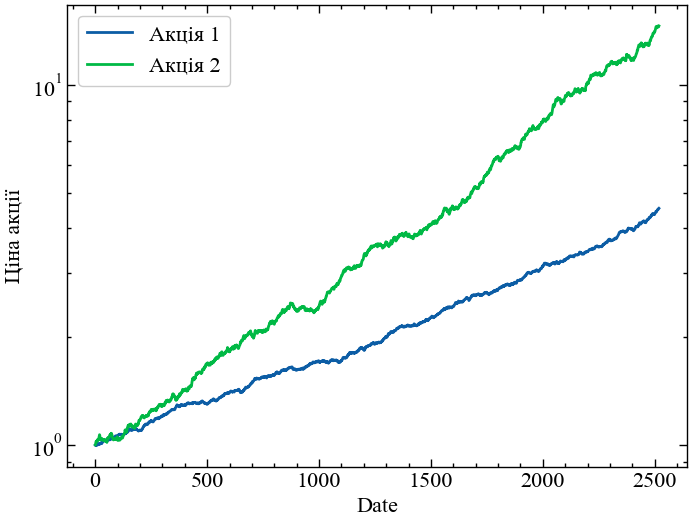

In [56]:
#| label: fig-gauss-stocks
#| fig-cap: "Динаміка двох акцій, що згенерована за Гаусовим розподілом у напів- логарифмічному масштабі$"

np.random.seed(1234)
n_years = 10

log_ret_1 = 0.0025*norm.rvs(size=n_years*252) + 0.0005
log_ret_2 = 0.0050*norm.rvs(size=n_years*252) + 0.0010

plt.figure()
plt.plot(np.exp(np.cumsum(log_ret_1)), label='Акція 1')
plt.plot(np.exp(np.cumsum(log_ret_2)), label='Акція 2')
plt.ylabel('Ціна акції')
plt.xlabel('Date')
plt.legend()
plt.yscale('log')
plt.show();

Звичайно, насправді ми не знаємо *справжньої* очікуваної прибутковості або значень волатильності кореляцій між активами. Таким чином, ми повинні оцінити очікувану прибутковість за середнім значенням вибірки та матрицю коваріації за матрицею коваріації вибірки. Зверніть увагу, що існують більш складні способи оцінки цих параметрів на основі історичних даних, таких як [оцінки усадки](http://www.ledoit.net/honey.pdf) для коваріаційної матриці або [моделі розподілу Блека-Літтермана](https://sci-hub.mksa.top/10.3905/jfi.1991.408013). Ці методи, безумовно, покращують вибіркові оцінки, але загальний недолік сучасної теорії портфеля через наявність "важких хвостів" залишається. Щоб вивчити та протестувати різні методи оптимізації портфеля, рекомендуємо розглянути бібліотеку [PyPortfolioOpt](https://pyportfolioopt.readthedocs.io/en/latest/index.html), що представляє собою добре задокументований пакет Python, який реалізує як основні, так і складні методи оптимізації портфеля та дозволяє легко тестувати ці методи на реальних даних. Поки ми дотримуємося вибіркових оцінок (і використовуємо коефіцієнт 252 --- середню кількість торгових днів на рік для отримання очікуваної прибутковості в річному обчисленні і коваріації за щоденними оцінками):

In [57]:
exp_returns = np.array([np.mean(log_ret_1), np.mean(log_ret_2)])*252
cov_matrix = np.cov([log_ret_1, log_ret_2])*252

Далі ми визначаємо функцію, яка приймає ваги розподілу кандидатів, розрахункову очікувану прибутковість і коваріаційну матрицю і виводить коефіцієнт Шарпа портфеля:

In [58]:
def sharpe(weights, exp_returns, cov_matrix):
    return weights.dot(exp_returns) / np.sqrt(weights.dot(cov_matrix).dot(weights.T))

sharpe(np.array([0.5, 0.5]), exp_returns, cov_matrix)

4.810679451759805

Замість того, щоб використовувати реальний оптимізатор для пошуку ваг розподілу, які максимізують коефіцієнт Шарпа, ми просто переглядаємо всі можливі комбінації ваг з інтервалом $1\%$. Звичайно, це розумний підхід лише для двох активів, і він швидко стає нерозв'язним, використовуючи більше двох активів.

In [59]:
candidate_weights = np.array([np.linspace(0, 1, 101), 1. - np.linspace(0, 1, 101)]).T
candidate_weights[:5]

array([[0.  , 1.  ],
       [0.01, 0.99],
       [0.02, 0.98],
       [0.03, 0.97],
       [0.04, 0.96]])

Тепер ми можемо перебрати всі наші ваги-кандидати, обчислити коефіцієнт Шарпа портфеля для всіх з них, а потім вибрати оптимальний набір ваг.

In [60]:
candidate_sharpe = [sharpe(weights, exp_returns, cov_matrix) for weights in candidate_weights]
opt_weights = candidate_weights[np.argmax(candidate_sharpe)]
opt_weights

array([0.7, 0.3])

Щоб отримати уявлення про те, наскільки точно ми можемо оцінити ваги розподілу на основі гіпотетичної щоденної прибутковості за 10 років, ми зараз повторюємо цей експеримент, повторно генеруємо нові випадкові прибутковості, повторно оцінюємо очікувані прибутковості й матрицю коваріації та знаходимо оптимальні ваги. Ми робимо це 10000 разів. Ми реєструємо лише першу вагу розподілу $w_1$ для кожного запуску без втрати інформації, оскільки друга вага безпосередньо випливає з нормалізації $w_2 = 1 - w_1$.

In [61]:
np.random.seed(1234)
opt_weight_gaussian = []

for i in tqdm(range(10000)):
    log_ret_1 = 0.0025*norm.rvs(size=n_years*252) + 0.0005
    log_ret_2 = 0.0050*norm.rvs(size=n_years*252) + 0.0010

    exp_returns = [np.mean(log_ret_1), np.mean(log_ret_2)]
    cov_matrix = np.cov([log_ret_1, log_ret_2])

    candidate_sharpe = [sharpe(weights, exp_returns, cov_matrix) for weights in candidate_weights]
    opt_weights = candidate_weights[np.argmax(candidate_sharpe)]

    opt_weight_gaussian.append(opt_weights[0])

100%|██████████| 10000/10000 [00:08<00:00, 1224.16it/s]


Нарешті, ми можемо побудувати гістограму всіх 10000 значень, які ми отримуємо для $w_1$.

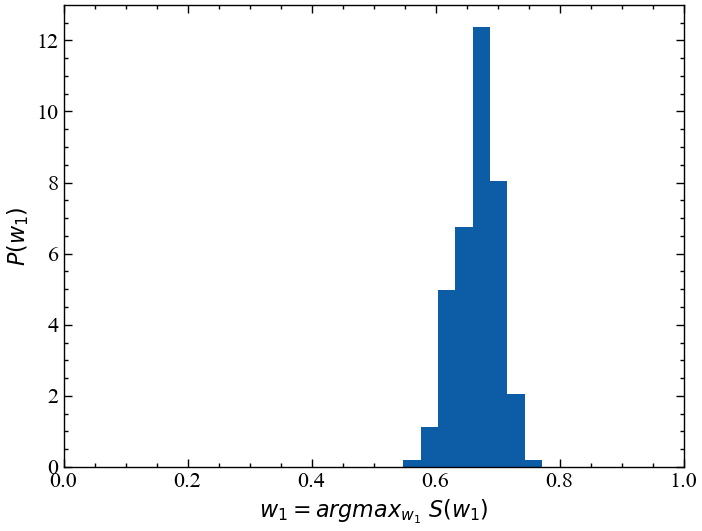

In [62]:
#| label: fig-coef-portfolio
#| fig-cap: "Розподіл імовірностей $w_1$ для портфеля з максимальним коефіцієнтом Шарпа. Портфель акцій розподілений за нормальним Гаусовим розподілом"

plt.figure()
plt.hist(opt_weight_gaussian, 10, density=True);
plt.xlim([0, 1])
plt.xlabel(r'$w_1 = argmax_{w_1} ~ S(w_1)$')
plt.ylabel(r'$P(w_1)$')
plt.show();

Як ми бачимо, розподіл для першої акції коливається приблизно від $60%$ до $70%$ на основі історичних даних за 10 років. Ми можемо додатково оцінити це кількісно, обчисливши 5-й і 95-й процентилі всіх значень $w_1$. Таким чином, з упевненістю в $90%$ ми отримаємо розподіл між $61%$ і $72%$:

In [63]:
np.percentile(opt_weight_gaussian, 5), np.percentile(opt_weight_gaussian, 95)

(0.61, 0.72)

Тепер давайте повторимо цей експеримент, але цього разу ми замінимо розподіл Гауса на розподіл Стьюдента зі степеневим показником $\alpha=3.7$ (що відповідає кількості ступенів свободи $\nu=2.7$). Ми залишаємо очікувану прибутковість і волатильність (виміряні стандартним відхиленням розподілу) точно такими ж. Зверніть увагу, що стандартне відхилення стандартного t-розподілу визначається як $\sqrt{\nu/(\nu-2)}$ в нашому випадку, тому ми повинні внести поправку на цей коефіцієнт маштабування при вилученні випадкових значень зі стандартного t-розподілу. Нижче ви можете побачити пряме порівняння розподілів Гауса, використаних у наведеному вище моделюванні, та t-розподілів із відповідним середнім значенням та стандартним відхиленням.

In [64]:
scale_correction = np.sqrt(2.7/(2.7-2.))

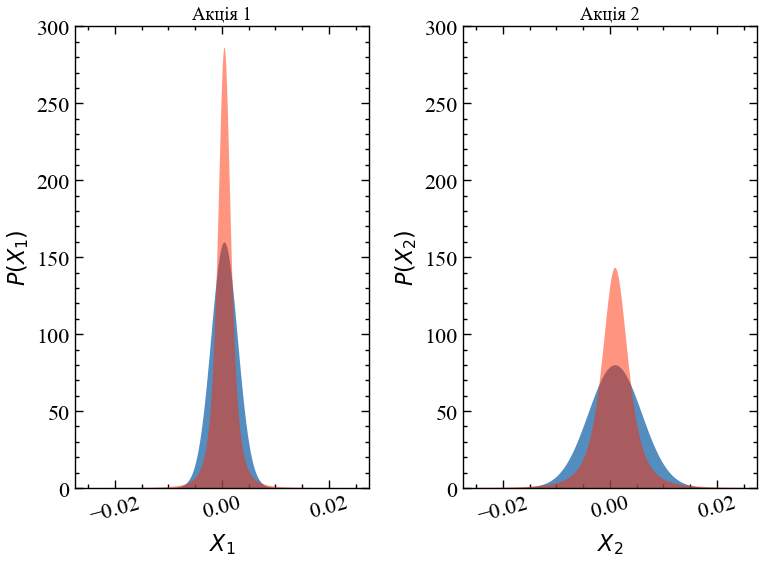

In [65]:
#| label: fig-dist-student-gaus
#| fig-cap: "Розподіл Стьюдента та Гауса для значень модельованих акцій"

x = np.linspace(-0.025, 0.025, 10000)

y1_norm = norm(loc=0.0005, scale=0.0025).pdf(x)
y1_t = t(loc=0.0005, scale=0.0025/scale_correction, df=2.7).pdf(x)

y2_norm = norm(loc=0.001, scale=0.005).pdf(x)
y2_t = t(loc=0.001, scale=0.005/scale_correction, df=2.7).pdf(x)


plt.figure()

plt.subplot(121)

plt.fill_between(x, 0., y1_norm, facecolor='C0', alpha=0.7)
plt.fill_between(x, 0., y1_t, facecolor='C3', alpha=0.5)
plt.ylim([0, 300])
plt.ylabel(r'$P(X_1)$')
plt.xlabel(r'$X_1$')
plt.xticks(rotation=15)
plt.title('Акція 1')

plt.subplot(122)
plt.fill_between(x, 0., y2_norm, facecolor='C0', alpha=0.7, label='Гаусіан')
plt.fill_between(x, 0., y2_t, facecolor='C3', alpha=0.5, label="Стьюдент")
plt.ylim([0, 300])
plt.ylabel(r'$P(X_2)$')
plt.xlabel(r'$X_2$')
plt.xticks(rotation=15)
plt.title('Акція 2')

plt.tight_layout()
plt.show(); 

Як ми можемо легко бачити, узгоджені t-розподіли Стьюдента насправді дають менші значення прибутковостей. Однак вони також дають набагато більш екстремальні значення, але ми не можемо легко побачити це, оскільки значення щільності ймовірності в хвостах дуже малі! Якщо ми перейдемо до логарифмічного масштабування вісі Oy, картина стане більш чіткою:

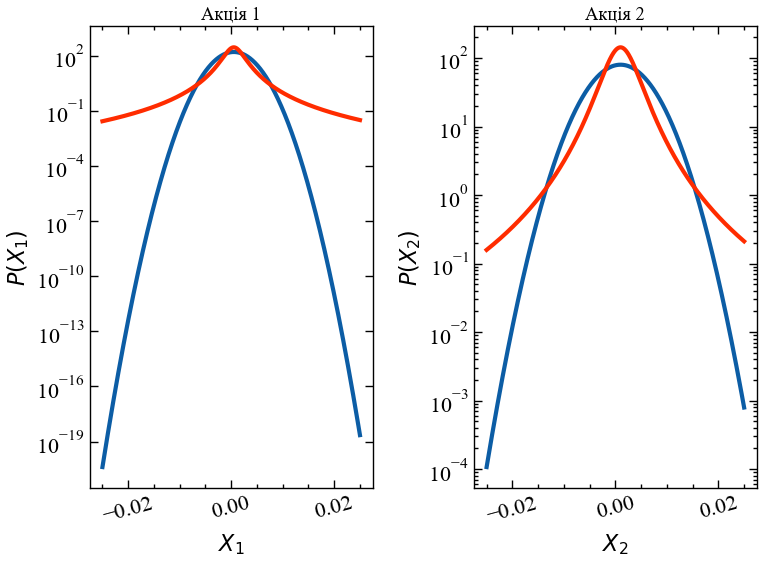

In [66]:
#| label: fig-dist-student-gaus-log
#| fig-cap: "Розподіл Стьюдента та Гауса для значень модельованих акцій у напів- логарифмічному масштабі"

plt.figure()

plt.subplot(121)

plt.plot(x, y1_norm, c='C0', lw=3)
plt.plot(x, y1_t, c='C3', lw=3)
plt.ylabel(r'$P(X_1)$')
plt.xlabel(r'$X_1$')
plt.xticks(rotation=15)
plt.title('Акція 1')
plt.yscale('log')

plt.subplot(122)
plt.plot(x, y2_norm, c='C0', lw=3, label='Гаусіан')
plt.plot(x, y2_t, c='C3', lw=3, label="Стьюдент")
plt.ylabel(r'$P(X_2)$')
plt.xlabel(r'$X_2$')
plt.xticks(rotation=15)
plt.title('Акція 2')
plt.yscale('log')

plt.tight_layout()
plt.show();

Тепер ми чітко бачимо, що, наприклад, ймовірність щоденних логарифмічних прибутковостей $-0.02$ для акції 1 в $10^{10}$ разів вища за умови t-розподілу порівняно з відповідним розподілом Гауса! Завжди дивіться на розподіли з логарифмічною шкалою щільності ймовірності, щоб отримати чітке уявлення про хвости. Використовуючи наші узгоджені t-розподіли, ми діємо, як і раніше, і моделюємо гіпотетичні 10-річні історичні показники для наших двох некорельованих акцій. Нижче ви можете побачити приклад. Тільки при уважному розгляді ви можете помітити, що ці криві сукупної прибутковості насправді трохи більш нерівні в порівнянні з тими, які були побудовані вище з гаусовими прибутковостями. Але різниця невловима, якщо дивитися на таку "наближену" діаграму десятирічного періоду:

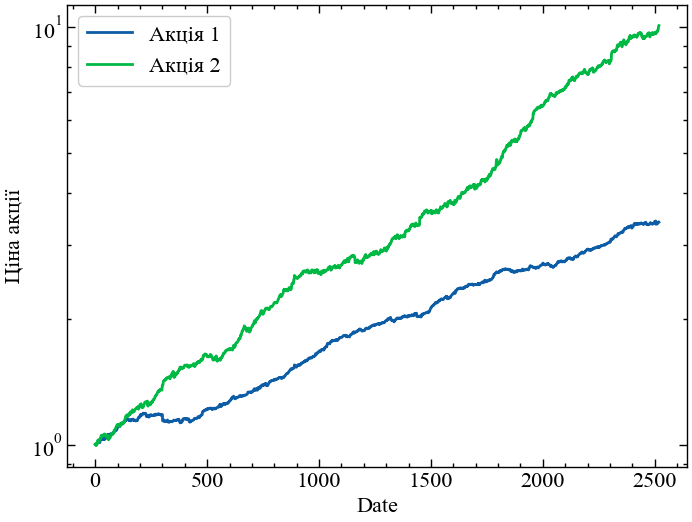

In [67]:
#| label: fig-student-stocks
#| fig-cap: "Динаміка двох акцій, що згенерована за розподілом Стьюдента у напів- логарифмічному масштабі"

np.random.seed(1234)
n_years = 10

log_ret_1 = (0.0025/scale_correction)*t.rvs(df=2.7, size=n_years*252) + 0.0005
log_ret_2 = (0.0050/scale_correction)*t.rvs(df=2.7, size=n_years*252) + 0.0010

plt.figure()
plt.plot(np.exp(np.cumsum(log_ret_1)), label='Акція 1')
plt.plot(np.exp(np.cumsum(log_ret_2)), label='Акція 2')

plt.ylabel('Ціна акції')
plt.xlabel('Date')
plt.legend()
plt.yscale('log')
plt.show();

Нарешті, щоб візуалізувати вплив t-розподілу на оцінку ваги розподілу, ми повторюємо наш експеримент Монте-Карло з моделювання 10000 різних 10-річних історичних значень та оцінюємо ваги розподілу в кожному з цих 10000 випадків. Потім ми будуємо графік розподілу $w_1$ і порівнюємо цей розподіл з розподілом, отриманим в результаті моделювання на основі Гауса.

In [68]:
np.random.seed(1234)
opt_weight_t = []

for i in tqdm(range(10000)):
    log_ret_1 = (0.0025/scale_correction)*t.rvs(df=2.7, size=n_years*252) + 0.0005
    log_ret_2 = (0.0050/scale_correction)*t.rvs(df=2.7, size=n_years*252) + 0.0010

    exp_returns = [np.mean(log_ret_1), np.mean(log_ret_2)]
    cov_matrix = np.cov([log_ret_1, log_ret_2])

    candidate_sharpe = [sharpe(weights, exp_returns, cov_matrix) for weights in candidate_weights]
    opt_weights = candidate_weights[np.argmax(candidate_sharpe)]

    opt_weight_t.append(opt_weights[0])

100%|██████████| 10000/10000 [00:10<00:00, 914.45it/s]


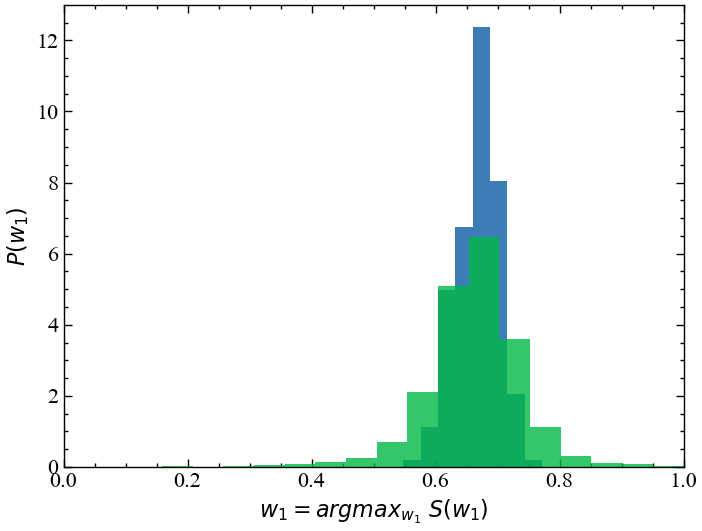

In [69]:
#| label: fig-coef-portfolio-gaus-stud
#| fig-cap: "Порівняння розподілів імовірностей $w_1$ для портфелів акцій з максимальним коефіцієнтом Шарпа. Портфелі розподілені за розподілами Гауса
#| та Стьюдента"

plt.figure()
plt.hist(opt_weight_gaussian, 10, alpha=0.8, density=True, label='Гаусові прибутковості')
plt.hist(opt_weight_t, 20, alpha=0.8, density=True, label="Прибутковості Стьюдента")
plt.xlim([0, 1])
plt.xlabel(r'$w_1 = argmax_{w_1} ~ S(w_1)$')
plt.ylabel(r'$P(w_1)$')
plt.show();

In [70]:
np.percentile(opt_weight_t, 5), np.percentile(opt_weight_t, 95)

(0.54, 0.77)

Як ми можемо бачити, оптимальна вага розподілу $w_1$ тепер коливається між $54\%$ і $77\%$, що приблизно в 2 рази перевищує ширину надійного інтервалу для оптимізації портфеля, яка дотримувалася припущення про гаусовість! Навіть при узгодженому стандартному відхиленні гаусового і t-розподілу, нескінченний ексцес t-розподілу дестабілізує вибіркову дисперсію наших змодельованих прибутковостей і, таким чином, знижує точність наших оціночних ваг розподілу. Хоча цей приклад, безумовно, не розкриває всіх слабкостей сучасної теорії портфеля, він допомагає нам побачити, як досить абстрактні ефекти, такі як нестабільність дисперсії через надмірний ексцес, в кінцевому результаті псують широко використовувані фінансові моделі. Використання модельованої прибутковості, заснованої на гаусовому розподілі порівняно з розподілом з великим хвостом, може допомогти виявити обмеження фінансових моделей або знайти мінімальний обсяг даних, необхідний для досягнення певної достовірності, перш ніж нова модель буде фактично запущена у виробництво!

::: {.callout-tip}
## Примітка

Важкі хвости розподілу прибутковостей можуть сильно вплинути на результати усталених математичних моделей у фінансах, або збільшуючи невизначеність параметрів (як у сучасній теорії портфеля), або приводячи до збоїв моделей поза вибірки через нескінченно великі моменти. У фінансах краще екстраполювати частоту екстремальних подій і готуватися до них за допомогою конкретних інструментів геджування, ніж намагатися передбачити майбутню прибутковість за допомогою моделей часових рядів!
:::

### Розподіл Леві

**Альфа-стабільний розподіл** є узагальненням розподілу Гауса, що враховує "важкі хвости". З цієї причини він широко використовується при обробці сигналів, наприклад, у медицині чи фінансах.

Загальний клас стабільних розподілів був введений і отримав цю назву французьким математиком Полем Леві на початку 1920-х років [@lévy1925calcul].

Раніше ця тема привертала лише помірну увагу провідних експертів. Натхненням для Леві стало бажання узагальнити відому центральну граничну теорему, згідно з якою будь-який розподіл імовірностей з кінцевою дисперсією збігається до розподілу Гауса.

Стабільні розподіли мають три виняткові властивості, які можна коротко підсумувати, заявляючи, що вони:

- інваріантні при додаванні;
- мають власну область збіжності;
- дозволяють канонічну форму характеристичної функції.

#### Інваріантність при додавані

*Випадкова величина $X$ підпорядковується стабільному розподілу $P(x) = \text{Prob}\{X \leq x\}$, якщо для будь-якого $n \geq 2$ існують додатнє значення $c_{n}$ та дійсне значення $d_{n}$ такі, що*

$$ 
X_1 + X_2 + ... + X_n \stackrel{d}{=} c_{n}X + d_{n}, 
$$

*де $X_1, X_2, ..., X_n$ характеризуються як незалежні, ідентично розподілені випадкові величини.* Також $\stackrel{d}{=}$ позначає *рівність розподілів*, тобто, випадкові величини з обох сторін мають однаковий розподіл імовірностей.

Загалом, сума незалежних, ідентично розподілених випадкових величин результує у випадкову величину з іншим розподілом. Однак, для випадкових величин, що характеризуються *стабільним* розподілом, сума ідентично розподілених випадкових величин прямує до величини такого самого розподілу [@lévy1954theorie;@gnedenko1968limit;@KOZUBOWSKI2005298]. У цьому випадку результуюча випадкова величина (розподіл) може відрізнятися від попередніх величин характерним масштабом ($c_{n}$) та зміщенням ($d_{n}$). Якщо $d_{n} = 0$, розподіл називається *строго стабільним*.

Відомо, що нормована константа $c_{n}$ має вид 

$$
c_{n} = n^{1/\alpha} \, \text{при} \,\, 0 < \alpha \leq 2. 
$$

Параметр $\alpha$ є **характеристичною експонентою** або **індексом стабільності** розподілу.

Попередня теорема має альтернативну версію, що включає в суму лише дві випадкові величини. *Випадкова величина $X$ підпорядковується стабільному розподілу, якщо для будь-яких позитивних значень $A$ та $B$ існує позитивне число $C$ та дійсне число $D$ такі, що*

$$ 
A X_1 + B X_2 \stackrel{d}{=} C X + D, 
$$

*де $X_1$ та $X_2$ незалежні копії $X$*. Тоді існує значення $\alpha \in (0, 2]$ при яких значення $C$ задовільняє рівність $C^{\alpha} = A^{\alpha} + B^{\alpha}$.

Для строго стабільних розподілів $D = 0$. Це означає, що всі лінійні комбінації випадкових незалежних, ідентично розподілених величин, що підкоряються строго стабільному розподілу, результують у випадкову величину з одним і тим же типом розподілу. 

Стабільний розподіл вважається *симетричним*, якщо величина $-X$ має такий самий тип розподілу. *Симетричний* стабільний розподіл обов'язково *строго стабільний*. 

Оскільки аналітичний вираз функції щільності ймовірностей для стабільного розподілу невідомий, за винятком кількох членів стабільного сімейства, більшість традиційних методів математичної статистики не можуть бути використані. Відповідними вийнятками є

1. **Гаусовий розподіл** $S_2(0,\mu, \sigma) = \mathcal{N}(\mu, 2\sigma^2)$. Гаусовий розподіл є спеціальним випадком стабільного розподілу при $\alpha = 2$ так що $\mathcal{N}(\mu, \sigma) = S(2,0,\mu, \frac{\sigma}{\sqrt{2}})$, де $\mu$ позначає середнє значення нормального розподілу, а $\sigma$ --- це стандартне відхилення. Функція щільності ймовірностей має вид 

$$ 
(\sigma\sqrt{2\pi})^{-1}\text{exp}\left[-(x-\mu)^{2}/2\sigma^{2}\right]. 
$$

2. **Розподіл Коші**. Розподіл Коші --- це ще одне представлення стабільного розподілу при $\alpha = 1$ та $\beta = 0$ такими, що $Cauchy(\delta, \gamma) = S_1(1,0,\gamma,\delta)$, де $\gamma$ --- це параметр масштабування, а $\delta$ --- це параметр зсуву розподілу Коші. Функція щільності ймовірностей представлена як: 

$$ 
\gamma \big/ \pi[(x-\delta)^2 + \gamma^2], \, -\infty < x < \infty. 
$$

3. **Розподіл Леві** також є вийнятком із класу стабільних розподілів, де $\alpha = 0.5$ і $\beta = 1$. Іншими словами, $Levy(\delta, \gamma) = S_{1/2}(0.5, 1, \gamma, \delta)$. Функція щільності ймовірностей має вид 

$$ 
\sqrt{\gamma/2\pi}(x-\delta)^{-3/2}\exp{\left[-\gamma/2(x-\delta) \right]}, \, \delta < x < \infty. 
$$

Якщо $X \sim S_{1/2}(0.5, 1, \gamma, \delta)$, тоді для $x > 0$

$$ 
P(X \leq x) = 2 \left[ 1 - \phi \left( \sqrt{\gamma/x} \right) \right], 
$$

де $\phi$ позначає кумулятивну функцію нормального розподілу.

#### Область збіжності

Інше (еквівалентне) визначення стверджує, що стабільні розподіли --- це єдині розподіли, які можна отримати при границі нормалізованих сум незалежних, ідентично розподілених випадкових величин. Кажуть, що випадкова величина $X$ має область збіжності, тобто якщо існує послідовність незалежних, ідентично розподілених випадкових величин $Y_1, Y_2, ...$ і послідовності позитивних чисел ${\gamma_n}$ і дійсних чисел ${\delta_n}$ таких, що

$$  
\left( Y_1 + Y_2 + ... + Y_n \right)/\gamma_n + \delta_n \stackrel{d}{\Rightarrow} X.  
$$

Коли $X$ це гаусова випадкова величина, а $Y_i$ є незалежними, ідентично розподіленими випадковими величинами з визначенною дисперсією, тоді рівняння вище є твердженням звичайної **центральної граничної теореми**. Область збіжності $X$ вважається *нормальною* коли $\gamma_n = n^{1/\alpha}$. 

#### Канонічні представлення характеристичної функції

Чотири параметри використовуються для опису випадкової величини, що слідує за стабільним розподілом: $X \sim S(\alpha, \beta, \mu, \gamma)$. Параметр $\alpha \in (0, 2]$ --- це той, який нас найбільше зацікавить. Цей параметр визначає товщину хвостів. Параметр $\beta \in [-1, 1]$ є параметром асиметрії. Останні два параметри позначають розташування $(\mu \in \Re)$ і масштаб $(\gamma > 0)$ розподілу. Альфа-стабільний розподіл немає жодного аналітичного виразу для щільності ймовірності $X$, але ми можемо охарактеризувати його характеристичною функцією [@JSFS_2005__146_4_23_0;@NOLAN1999229;@DBLP:conf/m3e2/BielinskyiSSS19]:

$$
    \begin{split}
    \phi(t) &= E\left[\exp(itX)\right] \\
            &= 
        \begin{cases} 
            \exp\left(i \mu t - \gamma^{\alpha}|t|^{\alpha} \left[1-i\beta\text{sign}(t)\tan(\pi\alpha/2\right]\right) & \text{при} \,\, \alpha \neq 1, \\ \exp\left(i \mu t - \gamma|t| \left[1+i\beta\text{sign}(t)(2/\pi)\log{|t|}\right]\right) & \text{при} \,\, \alpha = 1. 
        \end{cases} 
    \end{split}
$$

Ми могли б використовувати перетворення Фур'є, щоб отримати функцію щільності розподілу ймовірностей з характеристичної функції [@SALASGONZALEZ2013559]: 

$$ 
f(x) = \frac{1}{2\pi}\int_{-\infty}^{+\infty} \phi(t) \cdot \exp(-itX) dt. 
$$

Але наведена вище параметризація не є повністю задовільною, оскільки функція щільності розподілу ймовірностей не є неперервною, зокрема, при $\alpha = 1$. Дійсно, коли $\beta > 0$, щільність розподілу зміщується вправо, коли
$\alpha < 1$ і вліво, коли $\alpha > 1$, зі зсувом в сторону $+\infty$ (відповідно $-\infty$), коли $\alpha$ прагне до 1. Таким чином, для прикладного аналізу даних та інтерпретації коефіцієнтів слід уникати такої параметризації. 

Існує багато параметризацій для стабільних законів, і ці різні параметризації викликали велику плутанину. Різноманітність параметризацій обумовлена поєднанням історичної еволюції плюс численними проблемами, які були проаналізовані за допомогою спеціалізованих форм стабільного розподілу. Є вагомі причини використовувати різні параметризації в різних ситуаціях. Якщо в пріорітеті є чисельні розрахунки, робота із даними, то краще використовувати одну параметризацію. Якщо бажані прості алгебраїчні властивості розподілу або аналітичні властивості строго стійких законів, то краще розглянути дещо інші. Нолан запропонував використовувати параметризацію Золотарьова [@zolotarev1986one], яку також часто позначають як $S^{0}$. Характеристична функція, що відповідає $X \sim S^{0}(\alpha, \beta, \mu_{0}, \gamma)$, дорівнює:

$$
    \begin{split}
    \phi(t) &= E\left[\exp(itX)\right] \\
            &= 
        \begin{cases} 
            \exp\left(i \mu_{0} t - \gamma^{\alpha}|t|^{\alpha} \left[1+i\beta\text{sign}(t)\tan(\pi\alpha/2)\left( \gamma^{1-\alpha}|t|^{1-\alpha}-1 \right)\right]\right) & \text{при} \,\, \alpha \neq 1, \\ \exp\left(i \mu_{0} t - \gamma|t| \left[1+i\beta\text{sign}(t)(2/\pi)\left(\log{|t|} + \log{\gamma}\right) \right]\right) & \text{при} \,\, \alpha = 1. 
        \end{cases}
    \end{split} 
$$

Ця альтернативна параметризація недалека від зазначеної напочатку. Єдина відмінність стосується параметра $\mu$, який у даній параметризації коригує зсув для значень $\alpha$ близьких до 1:

$$ 
\mu_{0} = \begin{cases} \mu + \beta\gamma\tan(\pi\alpha/2) & \text{при} \,\, \alpha \neq 1, \\ \mu + \beta(2/\pi)\gamma\log{\gamma} & \text{при} \,\, \alpha = 1. \end{cases} 
$$

#### Метод розрахунку параметрів $\alpha$-стабільного розподілу

Числові методи, такі як метод заснований на квантилях [@doi:10.1080/01621459.1971.10482264;@doi:10.1080/03610918608812563;@MCCULLOCH1996393], і метод оцінки максимальної правдоподібності [@Nolan2001] були розроблені на виклик відсутності аналітичних рішень. Припустимо, що $\text{X} = (X_1, ... , X_T)$ вектор, що складається з $T$ незалежних ідентично розподілених випадкових величин із розподілу Парето, і також $x \sim S_{\alpha}(\alpha, \beta, \delta, \gamma)$. Визначивши $\theta = (\alpha, \beta, \delta, \gamma)$, Митник, Доганоглу та Ченайо використали алогритм максимальної правдоподібності і показали, що $\theta$ можна розрахувати, максимізуючи функцію логарифмічної правдоподібності [@MITTNIK1999275]:

$$ 
l(\theta, x) = \sum_{i=1}^{T}\log{f(x_{i}, \theta)}.
$$

Дюмушель визначив функцію правдоподібності наступним чином [@doi:10.1080/01621459.1973.10482458]: 

$$ 
L(\theta) = \prod_{k=1}^{n}S_{\alpha,\beta} \left[ (X_{k} - \delta)/\gamma \right] \big/ \gamma, 
$$ 

де $\theta = (\alpha, \beta, \delta, \gamma)$ опираючись на $x = (x_1, ... , x_n)$ для розміру вибірки $n$. 

## Хід роботи

Для демонстрації дієвості параметрів розподілу Леві в якості індикаторів (індикаторів-передвісників) крахових подій зчитаємо, наприклад, дані одного із фондових індексів Індії з Yahoo Finance:

In [72]:
# встановлення назви індексу
symbol = "^BSESN" 

# встановлення діапазону з яким будемо працювати
start = "1980-01-01"
end = "2023-11-07"

# завантаження даних з Yahoo
data = yf.download(symbol, start, end)
time_ser = data['Adj Close'].copy()

# підпис по вісі Ох 
xlabel = 'time, days'

# підпис по вісі Оу
ylabel = symbol                       

# збереження результату в текстовий документ 
np.savetxt(f'{symbol}_initial_time_series.txt', time_ser.values)

[*********************100%%**********************]  1 of 1 completed


::: {.callout-warning}
## Увага

Виконайте цей блок, якщо хочете зчитати дані не з Yahoo! Finance, а із власного файлу. Зрозуміло, що й аналіз результатів, і висновки залежать від того, з яким рядом ми працюємо

:::

---

In [3]:
symbol = 'sMpa11'                  # Символ індексу

path = "databases\sMpa11.txt"      # шлях по якому здійснюється зчитування файлу
data = pd.read_csv(path,           # зчитування даних 
                   names=[symbol])
time_ser = data[symbol].copy()     # копіюємо значення кривої 
                                   # "напруга-видовження" до окремої змінної

xlabel = r'$\varepsilon$'          # підпис по вісі Ох 
ylabel = symbol                    # підпис по вісі Оу

---

Виводимо графік досліджуваного ряду

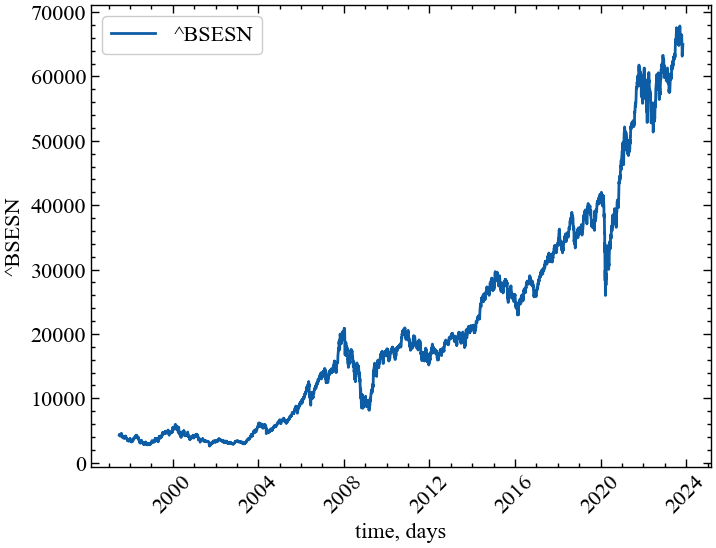

In [73]:
#| label: fig-bsesn-init 
#| fig-cap: "Динаміка щоденних значень фондового індексу BSESN"

fig, ax = plt.subplots()                   # Створюємо порожній графік
ax.plot(time_ser.index, time_ser.values)   # Додаємо дані до графіку
ax.legend([symbol])                        # Додаємо легенду
ax.set_xlabel(xlabel)                      # Встановимо підпис по вісі Ох
ax.set_ylabel(ylabel)                      # Встановимо підпис по вісі Oy

plt.xticks(rotation=45)                    # оберт позначок по осі Ох на 45 градусів

plt.savefig(f'{symbol}.jpg')               # Зберігаємо графік 
plt.show();                                # Виводимо графік

### Побудова розподілу Леві та розрахунок параметрів для всього ряду

Для приведення ряду до стандартизованого вигляду або прибутковостей визначимо функцію `transformations()`:

In [74]:
def transformation(signal, ret_type):

    for_rec = signal.copy()

    if ret_type == 1:       # Зважаючи на вид ряду, виконуємо
                            # необхідні перетворення
        pass
    elif ret_type == 2:
        for_rec = for_rec.diff()
    elif ret_type == 3:
        for_rec = for_rec.pct_change()
    elif ret_type == 4:
        for_rec = for_rec.pct_change()
        for_rec -= for_rec.mean()
        for_rec /= for_rec.std()
    elif ret_type == 5: 
        for_rec = for_rec.pct_change()
        for_rec -= for_rec.mean()
        for_rec /= for_rec.std()
        for_rec = for_rec.abs()
    elif ret_type == 6:
        for_rec -= for_rec.mean()
        for_rec /= for_rec.std()

    for_rec = for_rec.dropna().values

    return for_rec

Для побудови в парі певного індикатора та досліджуваного ряду визначимо функцію `plot_pair`:

In [75]:
def plot_pair(x_values, 
              y1_values,
              y2_values,  
              y1_label, 
              y2_label,
              x_label, 
              file_name, clr="magenta"):

    fig, ax = plt.subplots()

    ax2 = ax.twinx()
    ax2.spines.right.set_position(("axes", 1.03))

    p1, = ax.plot(x_values, 
                  y1_values, 
                  "b-", label=fr"{y1_label}")
    p2, = ax2.plot(x_values,
                   y2_values, 
                   color=clr, 
                   label=y2_label)

    ax.set_xlabel(x_label)
    ax.set_ylabel(f"{y1_label}")
    ax.yaxis.label.set_color(p1.get_color())
    ax2.yaxis.label.set_color(p2.get_color())

    tkw = dict(size=2, width=1.5)

    ax.tick_params(axis='x', **tkw)
    ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
    ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
    ax2.legend(handles=[p1, p2])

    plt.savefig(file_name + ".jpg")
        
    plt.show();

Далі виконаємо приведення ряду до прибутковостей:

In [76]:
ret_type = 4    # вид ряду: 
                # 1 - вихідний, 
                # 2 - детрендований (різниця між теп. значенням та попереднім)
                # 3 - прибутковості звичайні, 
                # 4 - стандартизовані прибутковості, 
                # 5 - абсолютні значення (волатильності)
                # 6 - стандартизований ряд 

for_levy = transformation(time_ser, ret_type)

Підганяємо розподіл Леві та Гауса для порівняння:

In [77]:
params = levy.fit_levy(for_levy)
mean, std = norm.fit(for_levy)

Отримуємо параметри розподілу Леві у відповідності до однієї із параметризацій, що пропонує пакет `levy`:

In [78]:
alpha, beta, mu, sigma = params[0].get('1')

Будуємо теоретичні та емпіричні розподіли:

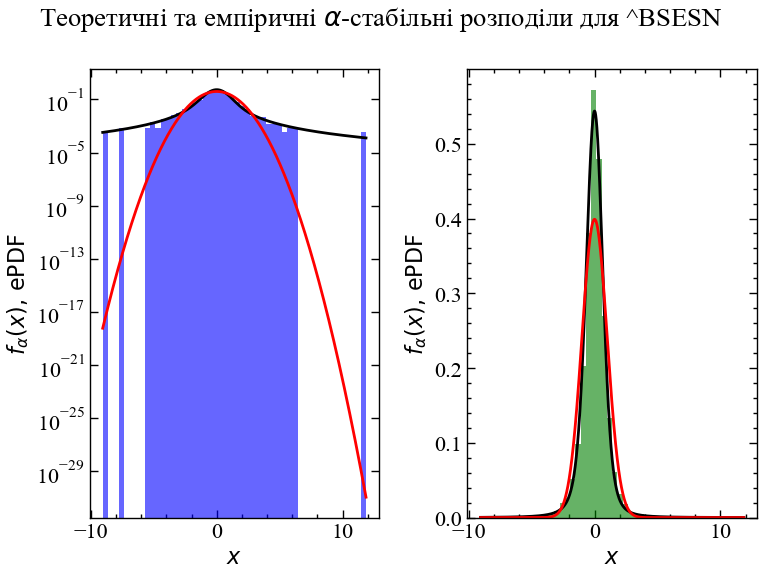

In [80]:
#| label: fig-pdfs-ther-emp 
#| fig-cap: "Теоретичні та емпіричні альфа-стабільні функції щільності ймовірностей"

xmin = for_levy.min()
xmax = for_levy.max()

x = np.linspace(xmin, xmax, len(for_levy))
pdf = levy.levy(x, alpha, beta, mu, sigma)
pdf_norm = norm.pdf(x, mean, std)

fig, ax = plt.subplots(1, 2)

fig.suptitle(fr'Теоретичні та емпіричні $\alpha$-стабільні розподіли для {symbol}')

ax[0].hist(for_levy, bins=50, density=True, alpha=0.6, color='b')
ax[0].plot(x, pdf, 'k')
ax[0].plot(x, pdf_norm, 'r')
ax[0].set_yscale('log')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$f_{\alpha}(x), \, \mathrm{ePDF}$')

ax[1].hist(for_levy, bins=50, density=True, alpha=0.6, color='g')
ax[1].plot(x, pdf, 'k')
ax[1].plot(x, pdf_norm, 'r')
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$f_{\alpha}(x), \, \mathrm{ePDF}$')

plt.savefig(f"Теоретичні та емпіричні альфа стабільні розподіли для {symbol}.jpg")

fig.tight_layout()
plt.show();

Виводимо параметри розподілу Леві для заданого індексу

In [81]:
print(fr"Параматери alpha = {alpha:.2f}, beta = {beta:.2f}, mu = {mu:.2f}, sigma = {sigma:.2f}")

Параматери alpha = 1.62, beta = -0.11, mu = -0.01, sigma = 0.52


Для досліджуваного індексу бачимо, що параметр $\alpha < 2.0$ та $\beta < 0$, що вказує на відхилення розподілу даного індексу від нормального. Тобто, для даного ряду суттєвими є кризові явища, на що вказують важкі хвости розподілу. Із порівняльного аналізу гаусового та Леві розподілів бачимо, що хвости нормального розподілу значно недооцінюють імовірність появи кризових явищ чого, наприклад, не скажеш про альфа-стабільний розподіл. Взявши логарифм значень імовірності по осі $Oy$, ми можемо спостерігати, що, наприклад, недооцінка негативних прибутковостей гаусовим розподілом, у порівнянні з альфа-стабільним, складає $\approx 10^{15}$ порядків. Для позитивних прибутковостей, що перевищують значення $+10\sigma$ недооцінка гаусовим розподілом складає $\approx 10^{27}$ порядків. Теоретичне значення альфа-стабільного розподілу достатньо точно враховує важкі хвости емпіричного розподілу, що також виражається високим ексцесом розподілу. Також варто зазначити, що коефіцієнт асиметрії $\beta$ вказує на невелике зміщення розподілу вліво, що також демонструє переважання кризових явищ. 

### Дослідження поведінки альфа-стабільного розподілу Леві

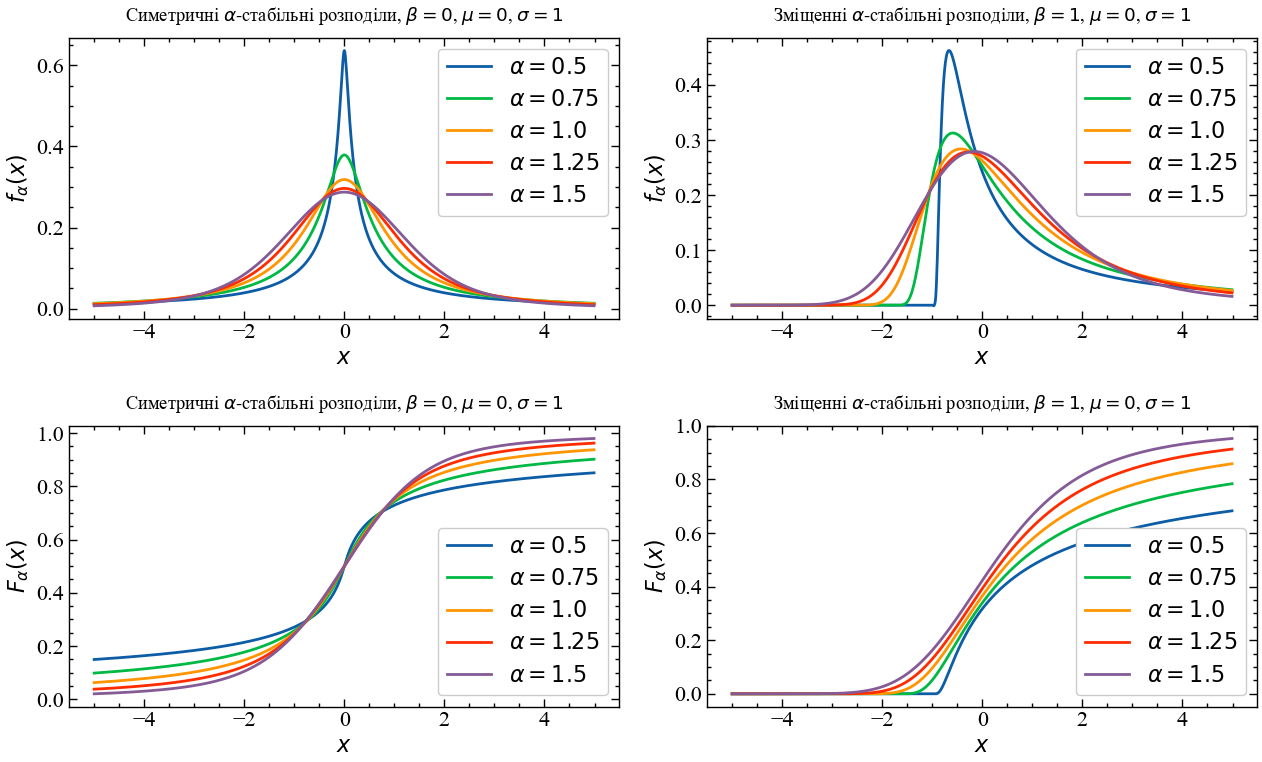

In [85]:
#| label: fig-pdfs-dependence 
#| fig-cap: "Залежність функції щільності ймовірностей альфа-стабільного розподілу Леві
#| та кумулятивної функції щільності від різних значень параметрів розподілу"

x = np.arange(-5, 5, .01)
beta_1 = 0
mu = 0 
sigm = 1 
beta_2 = 1.0

fig, ax = plt.subplots(2, 2, figsize=(13, 8))

ax[0][0].plot(x, levy.levy(x, 0.5, beta_1, mu, sigm), label = r"$\alpha=0.5$")
ax[0][0].plot(x, levy.levy(x, 0.75, beta_1, mu, sigm), label = r"$\alpha=0.75$")
ax[0][0].plot(x, levy.levy(x, 1.0, beta_1, mu, sigm), label = r"$\alpha=1.0 $")
ax[0][0].plot(x, levy.levy(x, 1.25, beta_1, mu, sigm), label = r"$\alpha=1.25$")
ax[0][0].plot(x, levy.levy(x, 1.5, beta_1, mu, sigm), label = r"$\alpha=1.5$")
ax[0][0].set_title(r"Симетричні $\alpha$-стабільні розподіли, $\beta = 0$, $\mu = 0$, $\sigma = 1$", y=1.03)
ax[0][0].legend()
ax[0][0].set_xlabel(r"$ x $")
ax[0][0].set_ylabel(r"$ f_{\alpha}(x) $")

ax[0][1].plot(x, levy.levy(x, 0.5, beta_2, mu, sigm), label = r"$\alpha=0.5$")
ax[0][1].plot(x, levy.levy(x, 0.75, beta_2, mu, sigm), label = r"$\alpha=0.75$")
ax[0][1].plot(x, levy.levy(x, 1.0, beta_2, mu, sigm), label = r"$\alpha=1.0$")
ax[0][1].plot(x, levy.levy(x, 1.25, beta_2, mu, sigm), label = r"$\alpha=1.25$")
ax[0][1].plot(x, levy.levy(x, 1.5, beta_2, mu, sigm), label = r"$\alpha=1.5$")
ax[0][1].set_title(r"Зміщенні $\alpha$-стабільні розподіли, $ \beta = 1 $, $ \mu = 0 $, $ \sigma = 1 $", y=1.03)
ax[0][1].legend()
ax[0][1].set_xlabel(r"$ x $")
ax[0][1].set_ylabel(r"$ f_{\alpha}(x) $")

ax[1][0].plot(x, levy.levy(x, 0.5, beta_1, mu, sigm, cdf=True), label = r"$ \alpha=0.5 $")
ax[1][0].plot(x, levy.levy(x, 0.75, beta_1, mu, sigm, cdf=True), label = r"$ \alpha=0.75 $")
ax[1][0].plot(x, levy.levy(x, 1.0, beta_1, mu, sigm, cdf=True), label = r"$ \alpha=1.0 $")
ax[1][0].plot(x, levy.levy(x, 1.25, beta_1, mu, sigm, cdf=True), label = r"$ \alpha=1.25 $")
ax[1][0].plot(x, levy.levy(x, 1.5, beta_1, mu, sigm, cdf=True), label = r"$ \alpha=1.5 $")
ax[1][0].set_title(r"Симетричні $\alpha$-стабільні розподіли, $ \beta = 0 $, $ \mu = 0 $, $ \sigma = 1 $", y=1.03)
ax[1][0].legend(loc="lower right")
ax[1][0].set_xlabel(r"$x$")
ax[1][0].set_ylabel(r"$F_{\alpha}(x)$")

ax[1][1].plot(x, levy.levy(x, 0.5, beta_2, mu, sigm, cdf=True), label = r"$ \alpha=0.5 $")
ax[1][1].plot(x, levy.levy(x, 0.75, beta_2, mu, sigm, cdf=True), label = r"$ \alpha=0.75 $")
ax[1][1].plot(x, levy.levy(x, 1.0, beta_2, mu, sigm, cdf=True), label = r"$ \alpha=1.0 $")
ax[1][1].plot(x, levy.levy(x, 1.25, beta_2, mu, sigm, cdf=True), label = r"$ \alpha=1.25 $")
ax[1][1].plot(x, levy.levy(x, 1.5, beta_2, mu, sigm, cdf=True), label = r"$ \alpha=1.5 $")
ax[1][1].set_title(r"Зміщенні $\alpha$-стабільні розподіли, $\beta = 1$, $\mu = 0$, $\sigma = 1$", y=1.03)
ax[1][1].legend(loc="lower right")
ax[1][1].set_xlabel(r"$x$")
ax[1][1].set_ylabel(r"$F_{\alpha}(x)$")

fig.tight_layout()
plt.show();

### Віконна процедура

Виконуватимемо подальші обчислення для стандартизованих прибутковостей, Покажемо, що та застосуємо альфа-стабільний розподіл Леві дозволяє змоделювати типові флуктуації складних систем та передчасної ідентифікації в них критичних і кризових явищ.

In [88]:
window = 250    # ширина ковзного вікна
tstep = 5       # крок

ret_type = 4    # вид ряду: 
                # 1 - вихідний, 
                # 2 - детрендований (різниця між теп. значенням та попереднім)
                # 3 - прибутковості звичайні, 
                # 4 - стандартизовані прибутковості, 
                # 5 - абсолютні значення (волатильності)
                # 6 - стандартизований ряд
        
length = len(time_ser)

alpha = []
beta = []
mu = []
sigma = []

In [89]:
for i in tqdm(range(0,length-window,tstep)):
    # відбираємо фрагмент
    fragm = time_ser.iloc[i:i+window].copy()  

    # виконуємо процедуру трансформації ряду 
    fragm = transformation(fragm, ret_type)
    
    # здійснюємо підгонку розподілу під значення ряду
    params = levy.fit_levy(fragm)
    
    # отримуємо параметри розподілу
    a, b, m, s = params[0].get('0')
    
    alpha.append(a)
    beta.append(b)
    mu.append(m)
    sigma.append(s)


100%|██████████| 1249/1249 [04:49<00:00,  4.32it/s]


Зберігаємо абсолютні значення у текстовому документі:

In [90]:
np.savetxt(f"alpha_idx_{symbol}_{window}_{tstep}_{ret_type}.txt", alpha)
np.savetxt(f"beta_idx_{symbol}_{window}_{tstep}_{ret_type}.txt", beta)
np.savetxt(f"mu_idx_{symbol}_{window}_{tstep}_{ret_type}.txt", mu)
np.savetxt(f"sigma_idx_{symbol}_{window}_{tstep}_{ret_type}.txt", sigma)

### Динаміка показника стабільності $\alpha$

Оголошуємо мітки для рисунків та назви збережених рисунків:

In [91]:
measure_label = r'$\alpha$'
file_name = f"alpha_idx_{symbol}_{window}_{tstep}_{ret_type}"

Виводимо результат:

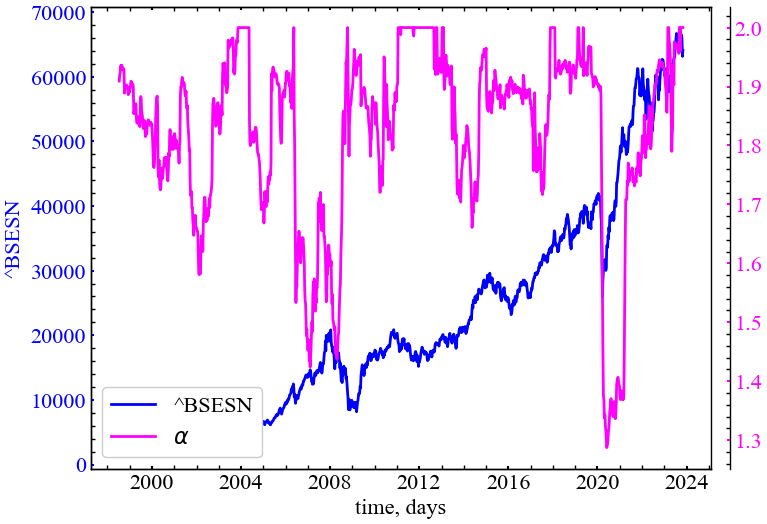

In [92]:
#| label: fig-alpha  
#| fig-cap: "Динаміка фондового індексу BSESN та показника стабільності $\\alpha$"

plot_pair(time_ser.index[window:length:tstep],
          time_ser.values[window:length:tstep],
          alpha, 
          ylabel, 
          measure_label,
          xlabel,
          file_name)

Параметр $\alpha$ (індекс стабільності хвостів розподілу) починає спадати у (перед)кризовий період, що робить його індикатором(-передвісником) кризових явищ. Під час криз у розподілі прибутковостей зростає ексцес, а самі хвости стають важчими, на що даний показник реагує передчасно.

### Динаміка показника асиметрії $\beta$

Оголошуємо мітки для рисунків та назви збережених рисунків:

In [93]:
measure_label = r'$\beta$'
file_name = f"beta_idx_{symbol}_{window}_{tstep}_{ret_type}"

Виводимо результат:

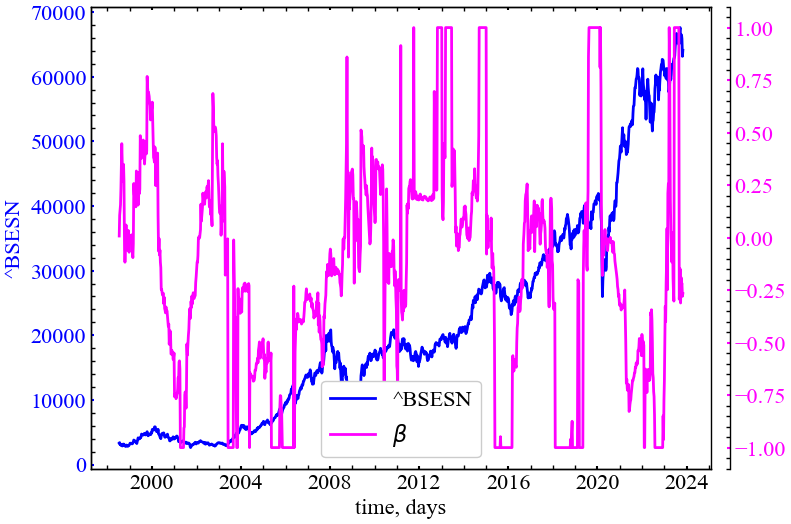

In [94]:
#| label: fig-beta  
#| fig-cap: "Динаміка фондового індексу BSESN та показника асиметрії $\\beta$"

plot_pair(time_ser.index[window:length:tstep],
          time_ser.values[window:length:tstep],
          beta, 
          ylabel, 
          measure_label,
          xlabel,
          file_name)

Динаміка даної міри виглядає набагато хаотичніше у порівнянні з індексом стабільності. Для представлених результатів можна зробити наступний висновок: у передкризовий період даний показник має зростати, вказуючи на значну правосторонню асиметрію розподілу прибутковостей (переважання позитивних прибутковостей). Для кризового періоду цей показник має спадати, вказуючи на домінацію негативних прибутковостей (лівостороння асиметрія розподілу). Даний показник важко розглядати у якості надійного індикатора, оскільки його коливання представляються значними навіть при незначних падіннях представленого фондового індексу. 

### Динаміка параметра зміщення $\mu$

Оголошуємо мітки для рисунків та назви збережених рисунків:

In [95]:
measure_label = r'$\mu$'
file_name = f"mu_idx_{symbol}_{window}_{tstep}_{ret_type}"

Виводимо результат:

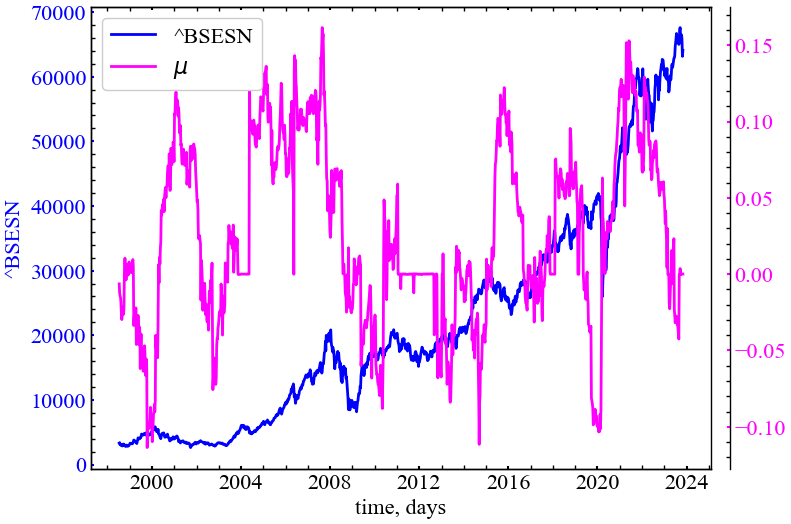

In [96]:
#| label: fig-mu  
#| fig-cap: "Динаміка фондового індексу BSESN та показника зміщення $\\mu$"

plot_pair(time_ser.index[window:length:tstep],
          time_ser.values[window:length:tstep],
          mu, 
          ylabel, 
          measure_label,
          xlabel,
          file_name)

Показник розташування $\mu$ потроху спадає у кризовий період, демонструючи зміщення розподілу в сторону негативних прибутковостей. Тим не менш, цей розподіл представляєть настільки ж хаотичним як і показник асиметрії $\beta$. 

### Динаміка параметра масштабу $\sigma$

Оголошуємо мітки для рисунків та назви збережених рисунків:

In [97]:
measure_label = r'$\sigma$'
file_name = f"sigma_idx_{symbol}_{window}_{tstep}_{ret_type}"

Виводимо результат:

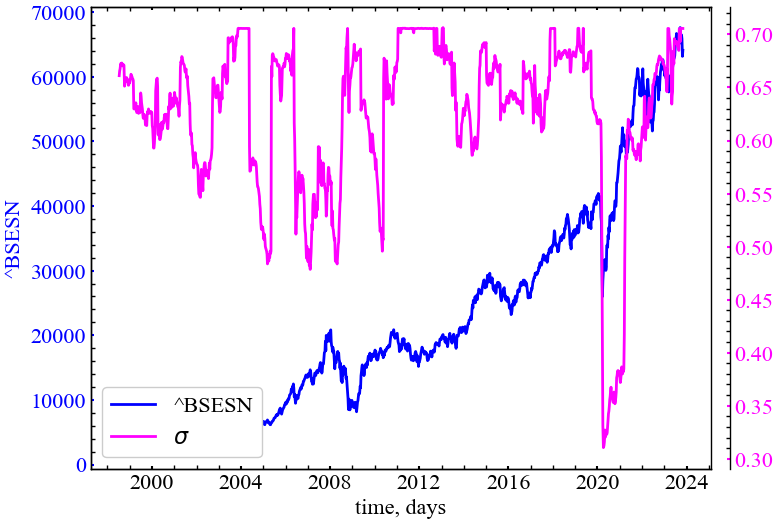

In [98]:
#| label: fig-sigma  
#| fig-cap: "Динаміка фондового індексу BSESN та показника масштабу $\\sigma$"

plot_pair(time_ser.index[window:length:tstep],
          time_ser.values[window:length:tstep],
          sigma, 
          ylabel, 
          measure_label,
          xlabel,
          file_name)

Із представлених результатів видно, що даний показник спадає у (перед)кризовий період, вказуючи на зменшення масштабу (форми) альфа-стабільного розподілу Леві.

Отже, з усіх 4-ох показників, показник стабільності $\alpha$ є найкращим для ідентифікації кризових явищ та побудови надійних стратегій ризик-менеджменту. 

## Висновок

Стабільні розподіли --- захоплюючий і плідний об'єкт досліджень в теорії ймовірностей; більше того, в даний час вони мають велику цінність при моделюванні складних процесів у фізиці, астрономії, економіці, теорії комунікацій тощо. 

У даній роботі було представлено теоретичні та чисельні обгрунтування в сторону альфа-стабільного розподілу Леві в якості практичної моделі для кращого розуміння та передбачення кризових явищ у складних системах.  

Тут ми представили розрахунки як для усього ряду, так і для його підфрагментів, використовуючи алгоритм ковзного вікна. Виходячи з усього ряду прибутковостей, видно, що хвости їх розподілу далеко виходять за межі Гаусового. Найкраще емпіричний розподіл прибутковостей збігається саме з теоретичним альфа-стабільним розподілом Леві. 

Використовуючи алгоритм сковзного вікна, ми побачили, що параметри альфа-стабільного розподілу змінюються з часом.

::: {.callout-tip}
## Література для подальшого вивчення степеневих розподілів та важких хвостів 

Nassim Taleb's [*Statistical Consequences of Fat Tails: Real World Preasymptotics, Epistemology, and Applications*](https://arxiv.org/ftp/arxiv/papers/2001/2001.10488.pdf) (вільно доступна за посиланням)
:::

## Завдання для самостійної роботи

1. Оберіть варіант ряду у викладача
2. Для вашого ряду побудуйте еміричний розподіл його прибутковостей і порівняйте його з розподілом Гауса та альфа-стабільним розподілом Леві. Проаналізуйте отримані результати
3. Використовуючи алгоритм ковзного вікна, дослідіть динаміку 4 ключових показників альфа-стабільного розподілу для вашого ряду і зробіть висновки